In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import acf
from scipy import stats
from scipy.stats import chi2, norm
import seaborn as sns
import yfinance as yf
from datetime import datetime

pd.set_option('display.max_columns', None)

In [2]:
# Define the date range
start = datetime(2020, 5, 1)
end = datetime(2025, 5, 1)

# Fetch data
df_ndx = yf.download('^NDX', start=start, end=end, auto_adjust=True)
df_jpm = yf.download('JPM', start=start, end=end, auto_adjust=True)
df_usdpln = yf.download('PLN=X', start=start, end=end, auto_adjust=True)
df_brent = yf.download('BZ=F', start=start, end=end, auto_adjust=True)
df_eth = yf.download('ETH-USD', start=start, end=end, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Drop the unnecessary level
dataframes = [df_ndx, df_jpm, df_usdpln, df_brent, df_eth]
tickers = ['NDX', 'JPM', 'USDPLN', 'Brent', 'ETH']

for df in dataframes:
    df.columns = df.columns.droplevel(1)

In [4]:
# Check NaN values
for name, df in zip(tickers, dataframes):
    print(f"NaN values in {name}: {df.isna().sum().sum()}")

NaN values in NDX: 0
NaN values in JPM: 0
NaN values in USDPLN: 0
NaN values in Brent: 0
NaN values in ETH: 0


In [5]:
# Join all close prices into a single DataFrame and drop rows with any NaNs
data = pd.concat([
    df_jpm['Close'].rename('JPMorgan'),
    df_usdpln['Close'].rename('USDPLN'),
    df_brent['Close'].rename('BrentOil'),
    df_eth['Close'].rename('Ethereum'),
    df_ndx['Close'].rename('NASDAQ')
], axis=1)

# Drop dates where any asset is missing (intersection of business days)
data.dropna(inplace=True)

In [6]:
# Only business days were considered for a simple reason: it would be impossible to rebalance the portfolio on weekends or holidays for all the assets,
# so rebalancing only on days when all assets are available is the most realistic approach. It's also worth adding that this approach gave better
# results than using all available data, including weekends and holidays.

In [7]:
data['PLNUSD'] = 1 / data['USDPLN']
data.drop(columns=['USDPLN'], inplace=True)

In [8]:
# We have to invert the USDPLN to PLNUSD because we will be trading PLN using USD.

In [9]:
data

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD
Date,,,,,
2020-05-01,80.753647,26.440001,214.219101,8718.179688,0.240912
2020-05-04,79.792412,27.200001,208.174011,8834.110352,0.239991
2020-05-05,79.671165,30.969999,206.774399,8930.620117,0.239892
2020-05-06,78.173004,29.719999,204.055786,8984.860352,0.238903
2020-05-07,78.987038,29.459999,212.289413,9101.879883,0.237444
...,...,...,...,...,...
2025-04-24,243.467056,66.550003,1769.831665,19214.400391,0.264375
2025-04-25,242.382294,66.870003,1786.634521,19432.560547,0.266406
2025-04-28,242.053879,65.860001,1798.851807,19427.289062,0.265867


In [10]:
prices = data.copy()

In [11]:
# Calculate log returns
for column in data.columns:
    data[column] = np.log(data[column]).diff()


data.dropna(inplace=True)

In [12]:
data

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD
Date,,,,,
2020-05-04,-0.011975,0.028339,-0.028625,0.013210,-0.003828
2020-05-05,-0.001521,0.129802,-0.006746,0.010865,-0.000415
2020-05-06,-0.018983,-0.041199,-0.013235,0.006055,-0.004130
2020-05-07,0.010359,-0.008787,0.039557,0.012940,-0.006126
2020-05-08,0.016204,0.049986,0.003302,0.012932,0.003177
...,...,...,...,...,...
2025-04-24,0.015489,0.006482,-0.014736,0.027497,-0.002817
2025-04-25,-0.004465,0.004797,0.009449,0.011290,0.007651
2025-04-28,-0.001356,-0.015219,0.006815,-0.000271,-0.002023


In [13]:
# Calculate portfolio log returns with equal weights for each asset for each day
n_assets = data.shape[1]
equal_weights = pd.DataFrame(1/n_assets, index=data.index, columns=data.columns)

portfolio_log_returns = (data * equal_weights).sum(axis=1)
data['portfolio'] = portfolio_log_returns

In [14]:
data

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD,portfolio
Date,,,,,,
2020-05-04,-0.011975,0.028339,-0.028625,0.013210,-0.003828,-0.000576
2020-05-05,-0.001521,0.129802,-0.006746,0.010865,-0.000415,0.026397
2020-05-06,-0.018983,-0.041199,-0.013235,0.006055,-0.004130,-0.014298
2020-05-07,0.010359,-0.008787,0.039557,0.012940,-0.006126,0.009589
2020-05-08,0.016204,0.049986,0.003302,0.012932,0.003177,0.017120
...,...,...,...,...,...,...
2025-04-24,0.015489,0.006482,-0.014736,0.027497,-0.002817,0.006383
2025-04-25,-0.004465,0.004797,0.009449,0.011290,0.007651,0.005744
2025-04-28,-0.001356,-0.015219,0.006815,-0.000271,-0.002023,-0.002411


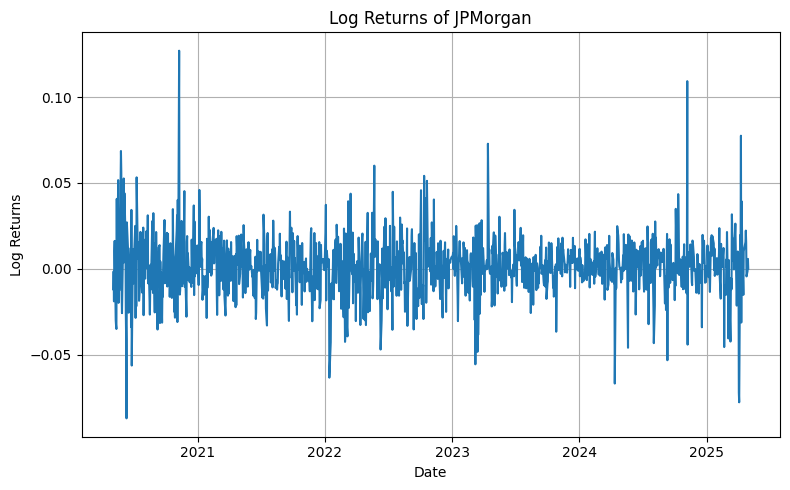

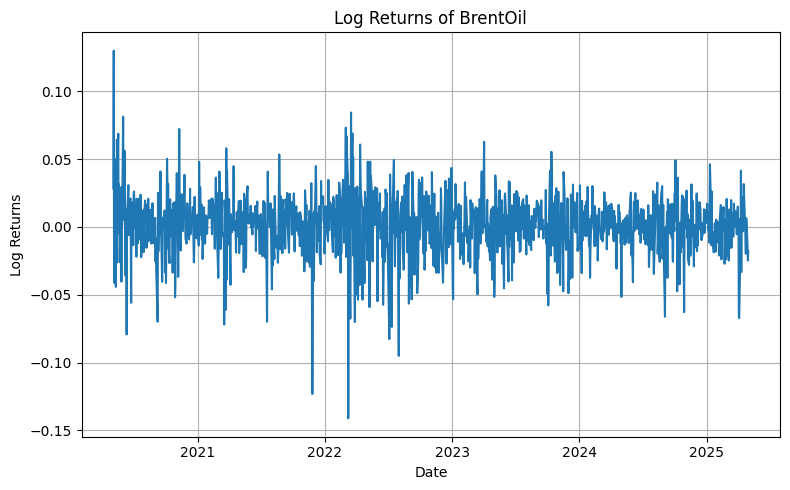

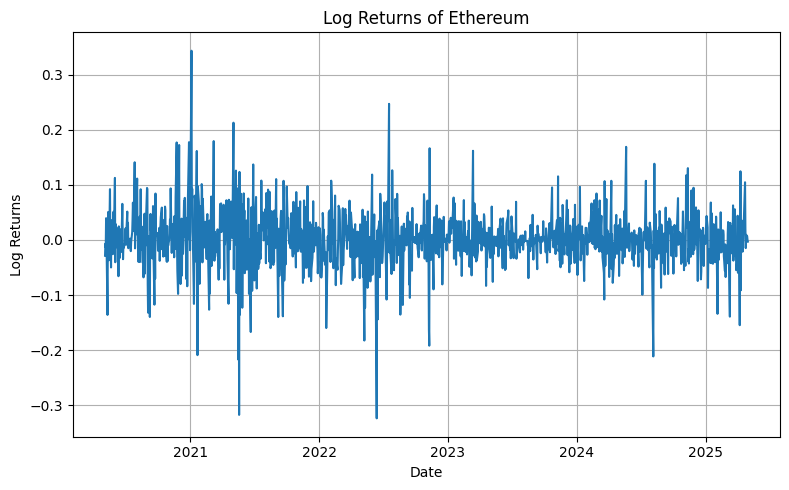

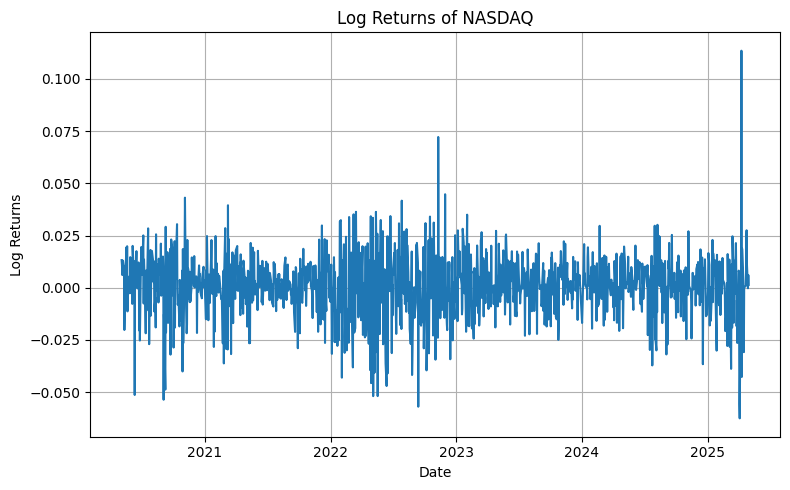

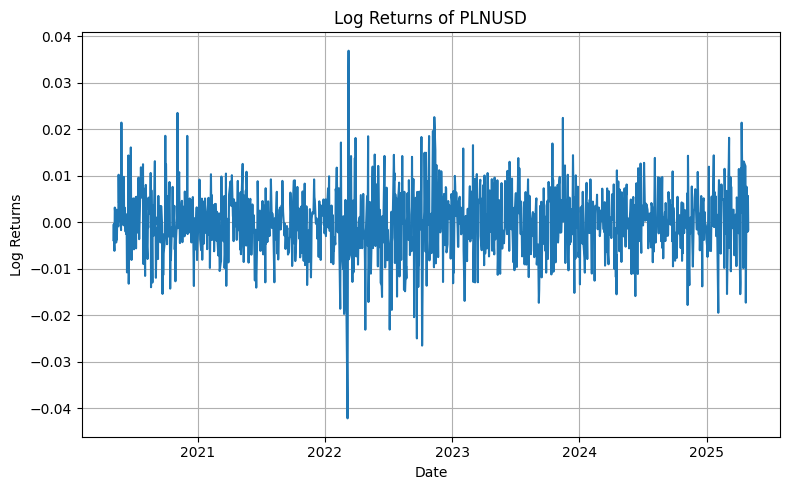

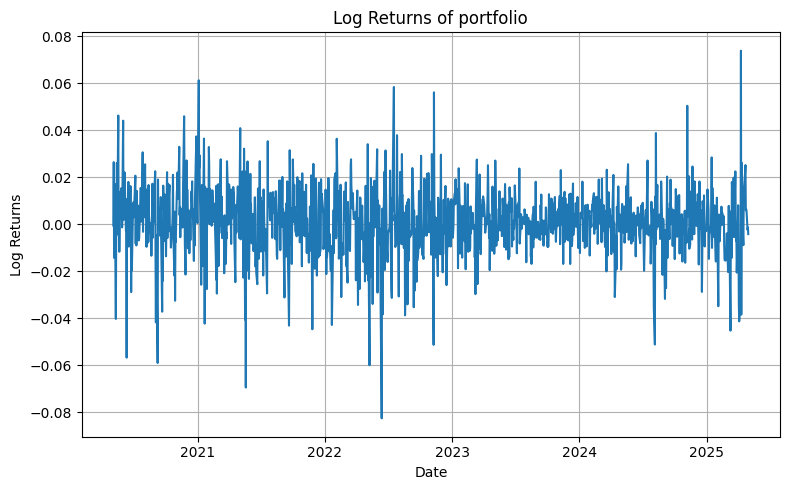

In [15]:
# Generate a plot of each column in the DataFrame
for column in data.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(data.index, data[column], label=column)
    plt.title(f'Log Returns of {column}')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [16]:
# On charts above we can easily observe volatility clustering, which is a good starting point for GARCH models. 
# For example, for portfolio returns there is a volatility cluster starting in year 2020, 
# and a volatility cluster that started in mid 2024.

In [17]:
for column in data.columns:
    print(f"Kurtosis of {column}:", stats.kurtosis(data[column]))

Kurtosis of JPMorgan: 5.8182380537587814
Kurtosis of BrentOil: 3.648798031420064
Kurtosis of Ethereum: 5.981940649369449
Kurtosis of NASDAQ: 3.7070779895463595
Kurtosis of PLNUSD: 1.9738819223832182
Kurtosis of portfolio: 3.422109949910195


In [18]:
# Kurtosis (Fisher's so we compare with 0 not 3) of all assets is greater than 0, indicating heavy tails and potential for extreme events.

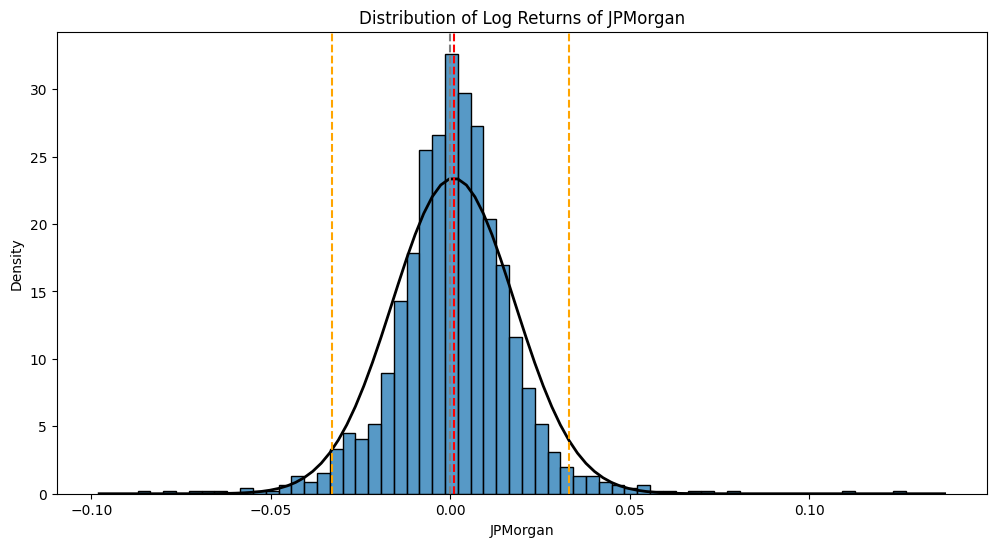

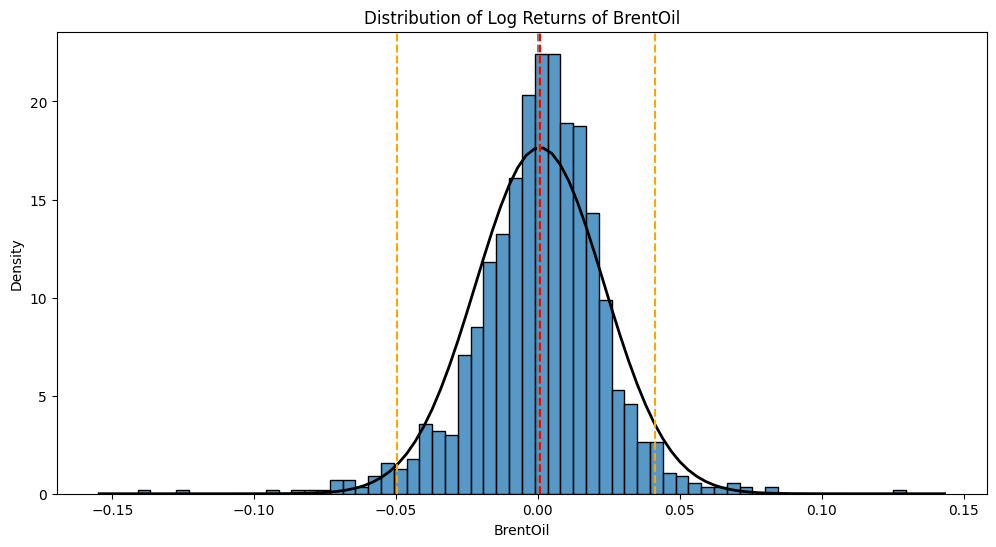

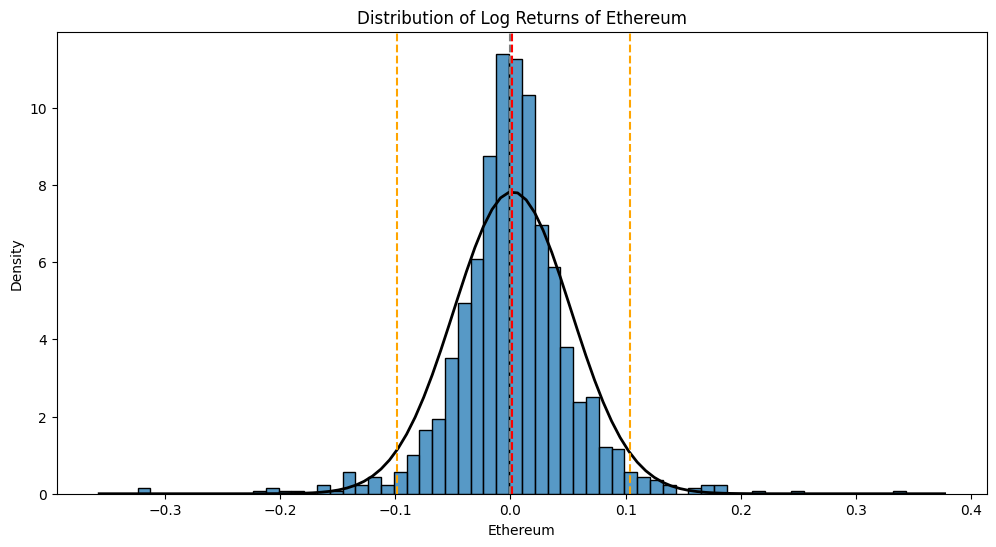

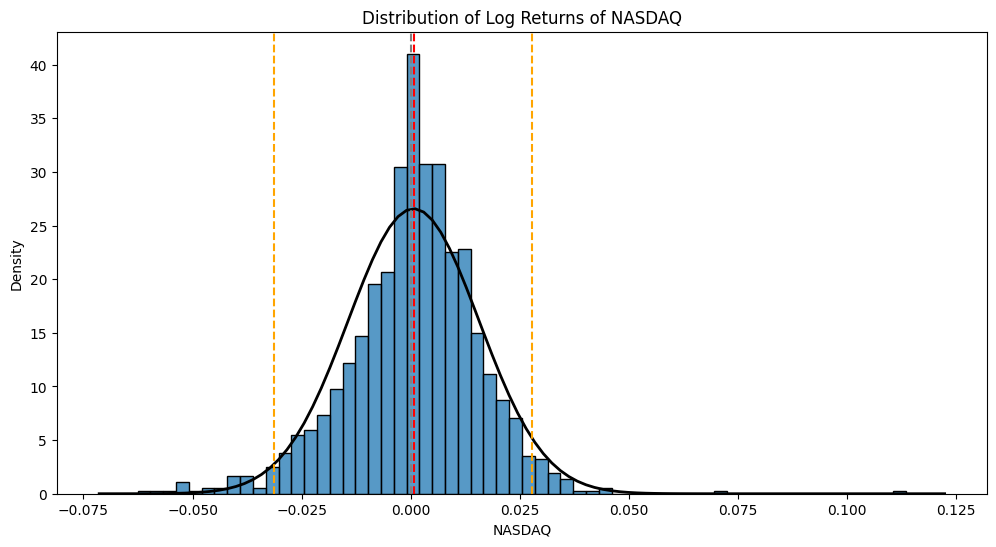

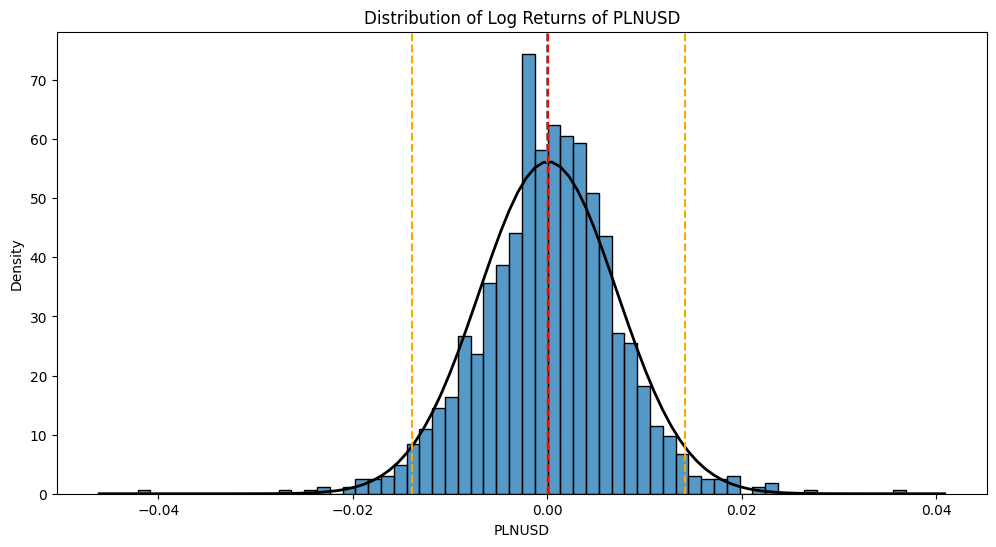

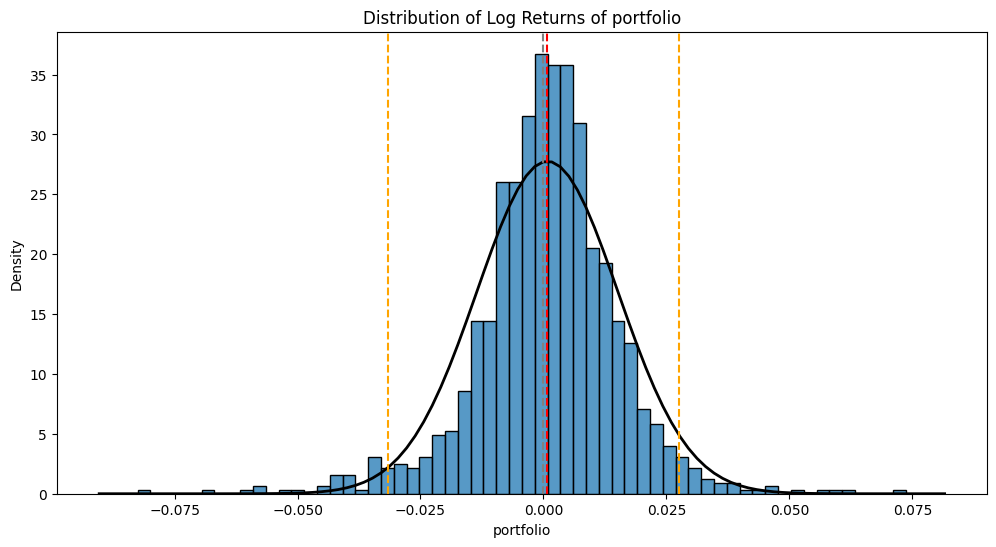

In [19]:
for column in data.columns:
    # Histogram of log returns
    plt.figure(figsize=(12, 6))
    sns.histplot(data[column], stat="density", bins = 60)
    # add normal distribution curve
    mu, std = data[column].mean(), data[column].std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.axvline(x=data[column].mean(), linestyle='--', color='red')
    plt.axvline(x=data[column].quantile(0.025), linestyle='--', color='orange')
    plt.axvline(x=data[column].quantile(0.975), linestyle='--', color='orange')
    plt.title(f'Distribution of Log Returns of {column}')
    plt.show()

In [20]:
for column in data.columns:
    jb_test = stats.jarque_bera(data[column])
    print(f"Jarque-Bera test statistic: {jb_test[0]:.2f}")
    print(f"p-value: {jb_test[1]:.2e}")

Jarque-Bera test statistic: 1792.03
p-value: 0.00e+00
Jarque-Bera test statistic: 738.35
p-value: 4.67e-161
Jarque-Bera test statistic: 1876.74
p-value: 0.00e+00
Jarque-Bera test statistic: 719.48
p-value: 5.84e-157
Jarque-Bera test statistic: 206.57
p-value: 1.39e-45
Jarque-Bera test statistic: 640.92
p-value: 6.68e-140


In [21]:
# All charts except PLNUSD (which visually might look a little bit more normal than others) show a distribution that deviates from normality, 
# with heavy tails and skewness, which is confirmed by the Jarque-Bera test.
# Leptokurtosis is evident in the histograms, with a peak higher than that of a normal distribution.
# The Jarque-Bera test for PLNUSD also indicates non-normality.

In [22]:
# H0: No ARCH effects
# H1: ARCH effects are present

for column in data.columns:
    arch_test_results = het_arch(data[column], nlags=5)

    print(f"LM Statistic {column}: {arch_test_results[0]:.3f}")
    print(f"p-value: {arch_test_results[1]:.3f}")
    print(f"F-statistic {column}: {arch_test_results[2]:.3f}")
    print(f"F p-value: {arch_test_results[3]:.3f}")

LM Statistic JPMorgan: 30.995
p-value: 0.000
F-statistic JPMorgan: 6.326
F p-value: 0.000
LM Statistic BrentOil: 76.300
p-value: 0.000
F-statistic BrentOil: 16.175
F p-value: 0.000
LM Statistic Ethereum: 38.395
p-value: 0.000
F-statistic Ethereum: 7.885
F p-value: 0.000
LM Statistic NASDAQ: 89.311
p-value: 0.000
F-statistic NASDAQ: 19.145
F p-value: 0.000
LM Statistic PLNUSD: 107.239
p-value: 0.000
F-statistic PLNUSD: 23.350
F p-value: 0.000
LM Statistic portfolio: 35.780
p-value: 0.000
F-statistic portfolio: 7.332
F p-value: 0.000


In [23]:
# We can see that ARCH effects are present for all assets separately as well as for the whole portfolio.

In [24]:
for column in data.columns:
    ljung_box_test_5 = sm.stats.acorr_ljungbox(data[column]**2, lags=[5], return_df=True)
    ljung_box_test_10 = sm.stats.acorr_ljungbox(data[column]**2, lags=[10], return_df=True)
    ljung_box_test_15 = sm.stats.acorr_ljungbox(data[column]**2, lags=[15], return_df=True)
    ljung_box_test_20 = sm.stats.acorr_ljungbox(data[column]**2, lags=[20], return_df=True)
    print(f"Ljung-Box test for {column} at lag 5: {ljung_box_test_5['lb_stat'].values[0]:.3f}, p-value: {ljung_box_test_5['lb_pvalue'].values[0]:.3f}")
    print(f"Ljung-Box test for {column} at lag 10: {ljung_box_test_10['lb_stat'].values[0]:.3f}, p-value: {ljung_box_test_10['lb_pvalue'].values[0]:.3f}")
    print(f"Ljung-Box test for {column} at lag 15: {ljung_box_test_15['lb_stat'].values[0]:.3f}, p-value: {ljung_box_test_15['lb_pvalue'].values[0]:.3f}")
    print(f"Ljung-Box test for {column} at lag 20: {ljung_box_test_20['lb_stat'].values[0]:.3f}, p-value: {ljung_box_test_20['lb_pvalue'].values[0]:.3f}")


Ljung-Box test for JPMorgan at lag 5: 40.385, p-value: 0.000
Ljung-Box test for JPMorgan at lag 10: 47.669, p-value: 0.000
Ljung-Box test for JPMorgan at lag 15: 64.591, p-value: 0.000
Ljung-Box test for JPMorgan at lag 20: 68.919, p-value: 0.000
Ljung-Box test for BrentOil at lag 5: 87.666, p-value: 0.000
Ljung-Box test for BrentOil at lag 10: 150.051, p-value: 0.000
Ljung-Box test for BrentOil at lag 15: 174.005, p-value: 0.000
Ljung-Box test for BrentOil at lag 20: 205.320, p-value: 0.000
Ljung-Box test for Ethereum at lag 5: 49.002, p-value: 0.000
Ljung-Box test for Ethereum at lag 10: 71.261, p-value: 0.000
Ljung-Box test for Ethereum at lag 15: 93.162, p-value: 0.000
Ljung-Box test for Ethereum at lag 20: 99.135, p-value: 0.000
Ljung-Box test for NASDAQ at lag 5: 123.147, p-value: 0.000
Ljung-Box test for NASDAQ at lag 10: 147.325, p-value: 0.000
Ljung-Box test for NASDAQ at lag 15: 159.635, p-value: 0.000
Ljung-Box test for NASDAQ at lag 20: 181.408, p-value: 0.000
Ljung-Box tes

In [25]:
# There is a significant autocorrelation in the squared log returns of all assets which means that GARCH models are appropriate for modeling the volatility of these assets. 

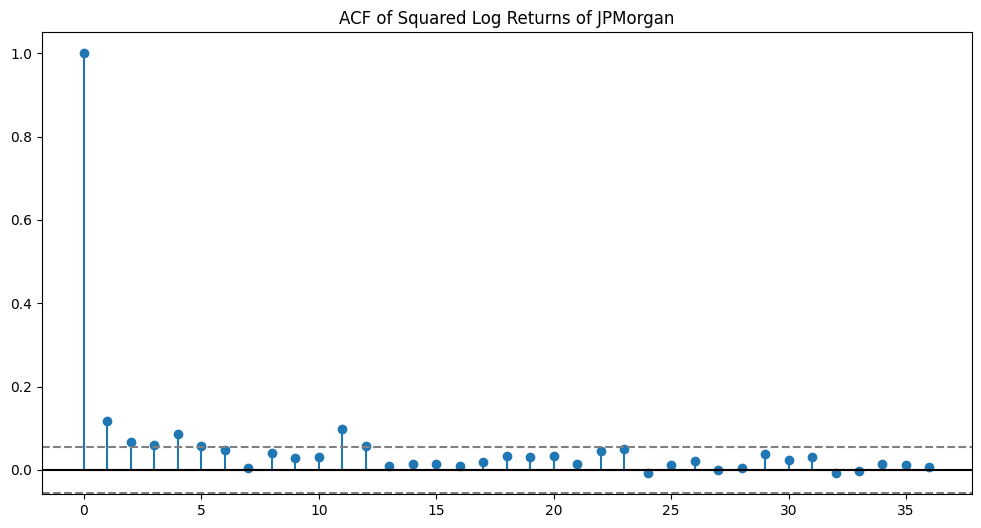

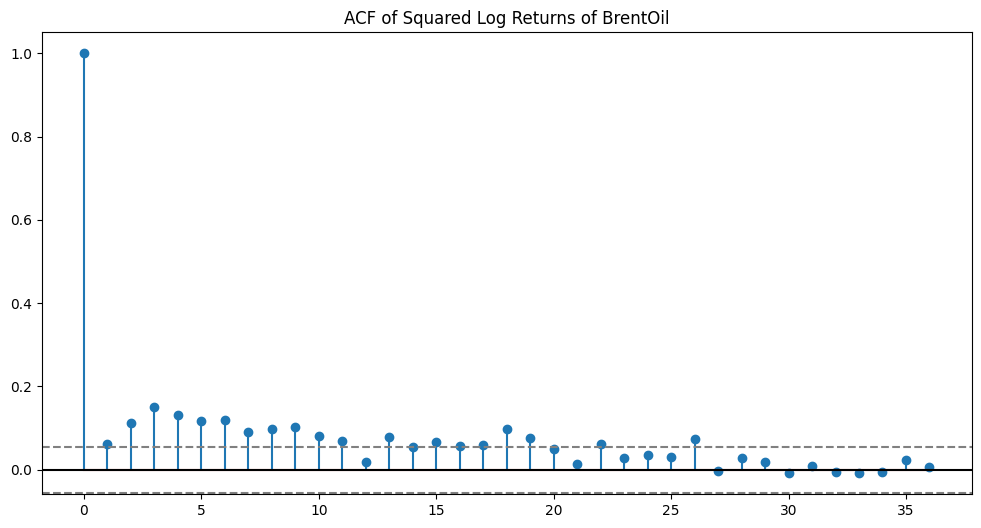

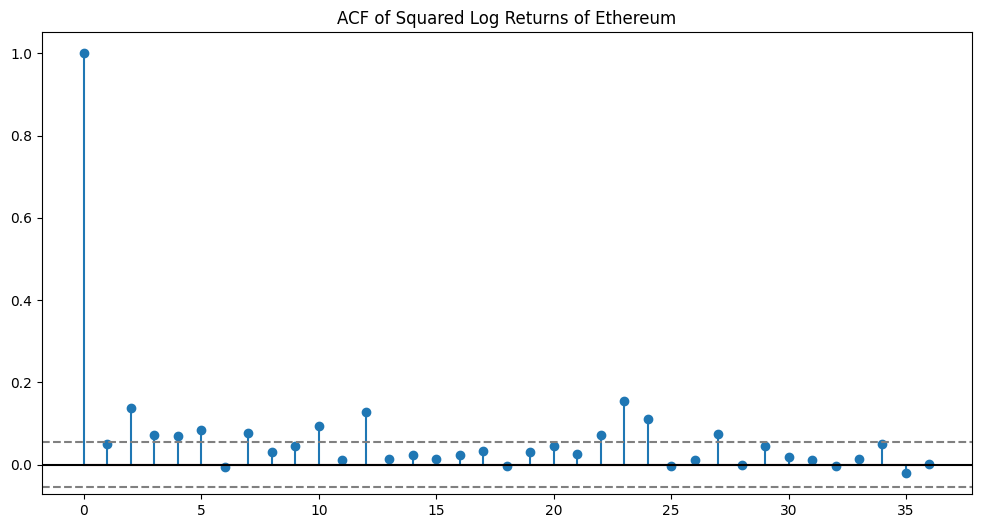

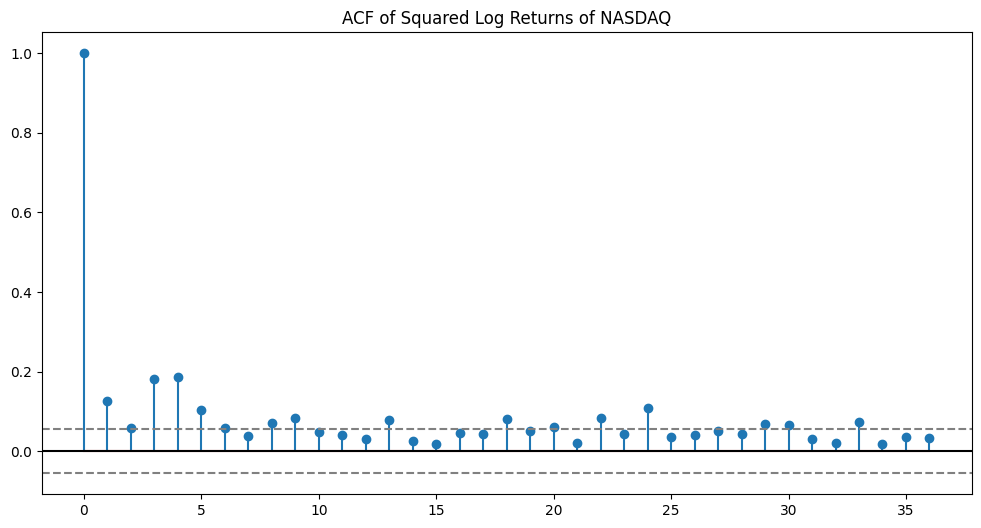

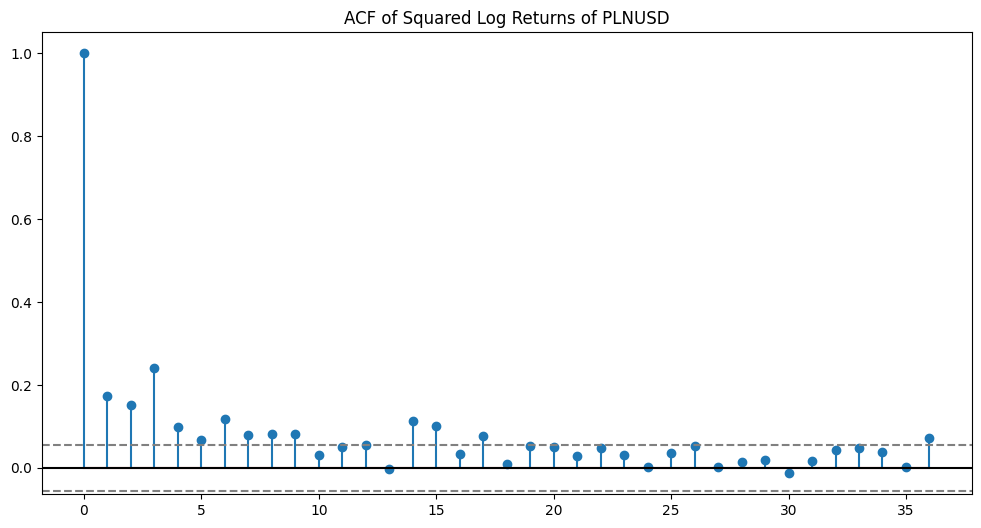

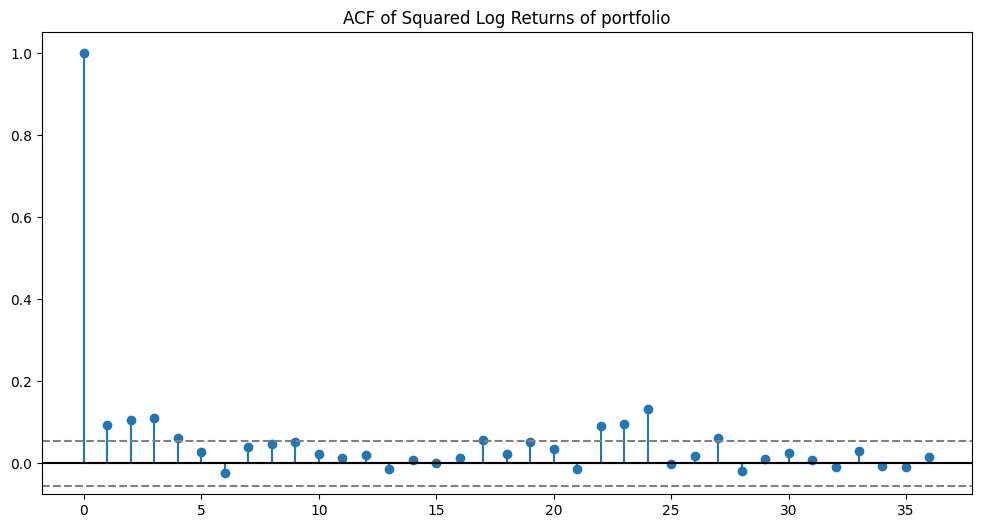

In [26]:
for column in data.columns:
    # Autocorrelation function for squared log returns
    acf_squared = acf(data[column]**2, nlags=36)
    plt.figure(figsize=(12, 6))
    plt.stem(range(len(acf_squared)), acf_squared)
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(data[column])), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data[column])), linestyle='--', color='gray')
    plt.title(f'ACF of Squared Log Returns of {column}')
    plt.show()

In [27]:
# Charts above show that there are significant autocorrelations in squared log returns, which is a characteristic of volatility clustering.

In [28]:
# Split the data into training and test sets
data_train = data[data.index < '2024-05-01'].copy()
data_test = data[data.index >= '2024-05-01'].copy()
data_train

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD,portfolio
Date,,,,,,
2020-05-04,-0.011975,0.028339,-0.028625,0.013210,-0.003828,-0.000576
2020-05-05,-0.001521,0.129802,-0.006746,0.010865,-0.000415,0.026397
2020-05-06,-0.018983,-0.041199,-0.013235,0.006055,-0.004130,-0.014298
2020-05-07,0.010359,-0.008787,0.039557,0.012940,-0.006126,0.009589
2020-05-08,0.016204,0.049986,0.003302,0.012932,0.003177,0.017120
...,...,...,...,...,...,...
2024-04-24,0.004881,-0.004534,-0.025193,0.003162,0.006269,-0.003083
2024-04-25,0.001501,0.011185,0.005306,-0.005510,-0.006213,0.001254
2024-04-26,0.000620,0.005490,-0.008381,0.016377,0.007059,0.004233


In [29]:
# Below only GARCH (1,1) and EGARCH (1,2,1) models will be interpreted, as they later tuned out to be the best performing models.

In [30]:
model_garch11 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=1)
results_garch11 = model_garch11.fit(disp='off')
print(results_garch11.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.70
Distribution:                  Normal   AIC:                           3505.40
Method:            Maximum Likelihood   BIC:                           3525.05
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1017  4.018e-02      2.531  1.139e-02 [2.293e-0

In [31]:
# Mu (unconditional mean return) is statistically significant, indicating that the mean return is above zero.
# Omega (long-term average volatility) is not statistically significant, suggesting that the long-term average volatility is not significantly different from zero.
# Alpha[1] (past squared residuals) is statistically significant, indicating that shocks have a significant impact on current volatility.
# Beta[1] (past conditional volatility) is statistically significant, indicating that past volatility has a significant impact on current volatility.
# All parameters have correct signs, and the sum of alpha and beta is smaller than 1, which indicates stationarity of variance.

In [32]:
model_garch12 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=2)
results_garch12 = model_garch12.fit(disp='off')
print(results_garch12.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.69
Distribution:                  Normal   AIC:                           3507.37
Method:            Maximum Likelihood   BIC:                           3531.94
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1018  4.026e-02      2.530  1.141e-02 [2.294e-0

In [33]:
model_garch21 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=1)
results_garch21 = model_garch21.fit(disp='off')
print(results_garch21.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.70
Distribution:                  Normal   AIC:                           3507.40
Method:            Maximum Likelihood   BIC:                           3531.96
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1017  4.118e-02      2.469  1.354e-02 [2.097e-0

In [34]:
model_garch22 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=2)
results_garch22 = model_garch22.fit(disp='off')
print(results_garch22.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.20
Distribution:                  Normal   AIC:                           3508.39
Method:            Maximum Likelihood   BIC:                           3537.87
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1013  4.003e-02      2.532  1.135e-02 [2.288e-0

In [35]:
model_garch10 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=0)
results_garch10 = model_garch10.fit(disp='off')
print(results_garch10.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1798.09
Distribution:                  Normal   AIC:                           3602.18
Method:            Maximum Likelihood   BIC:                           3616.91
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1141  4.554e-02      2.506  1.221e-02 [2.487e-0

In [36]:
model_garch20 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=0)
results_garch20 = model_garch20.fit(disp='off')
print(results_garch20.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1782.18
Distribution:                  Normal   AIC:                           3572.37
Method:            Maximum Likelihood   BIC:                           3592.02
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1376  4.309e-02      3.194  1.405e-03 [5.316e-0

In [37]:
model_garch31 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=3, q=1)
results_garch31 = model_garch31.fit(disp='off')
print(results_garch31.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.70
Distribution:                  Normal   AIC:                           3509.40
Method:            Maximum Likelihood   BIC:                           3538.88
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1017  4.210e-02      2.415  1.573e-02 [1.916e-0

In [38]:
model_garch32 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=3, q=2)
results_garch32 = model_garch32.fit(disp='off')
print(results_garch32.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.20
Distribution:                  Normal   AIC:                           3510.39
Method:            Maximum Likelihood   BIC:                           3544.78
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1013  4.105e-02      2.469  1.356e-02 [2.089e-0

In [39]:
model_garch13 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=3)
results_garch13 = model_garch13.fit(disp='off')
print(results_garch13.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.30
Distribution:                  Normal   AIC:                           3508.59
Method:            Maximum Likelihood   BIC:                           3538.07
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1037  4.100e-02      2.530  1.142e-02 [2.335e-0

In [40]:
model_garch23 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=3)
results_garch23 = model_garch23.fit(disp='off')
print(results_garch23.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1746.90
Distribution:                  Normal   AIC:                           3507.80
Method:            Maximum Likelihood   BIC:                           3542.19
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1050  3.965e-02      2.649  8.072e-03 [2.732e-0

In [41]:
model_garch33 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=3, q=3)
results_garch33 = model_garch33.fit(disp='off')
print(results_garch33.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1746.90
Distribution:                  Normal   AIC:                           3509.80
Method:            Maximum Likelihood   BIC:                           3549.10
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1050  3.982e-02      2.638  8.333e-03 [2.701e-0

In [42]:
models = {
    'GARCH(1,1)': results_garch11,
    'GARCH(1,2)': results_garch12,
    'GARCH(2,1)': results_garch21,
    'GARCH(2,2)': results_garch22,
    'GARCH(1,0)': results_garch10,
    'GARCH(2,0)': results_garch20,
    'GARCH(3,1)': results_garch31,
    'GARCH(3,2)': results_garch32,
    'GARCH(1,3)': results_garch13,
    'GARCH(2,3)': results_garch23,
    'GARCH(3,3)': results_garch33
}

In [43]:
def compare_arch_models(model_results_dict):
    if not model_results_dict:
        print("No model results provided.")
        return pd.DataFrame()

    ic_data = []
    for name, model in model_results_dict.items():
        ic_data.append({
            'Model': name,
            'lb_5' : sm.stats.acorr_ljungbox(model.std_resid, lags=[5], return_df=True)['lb_pvalue'].iloc[0],
            'lb_10' : sm.stats.acorr_ljungbox(model.std_resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0],
            'lb_15' : sm.stats.acorr_ljungbox(model.std_resid, lags=[15], return_df=True)['lb_pvalue'].iloc[0],
            'lb_20' : sm.stats.acorr_ljungbox(model.std_resid, lags=[20], return_df=True)['lb_pvalue'].iloc[0],
            'lb_sq_5' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[5], return_df=True)['lb_pvalue'].iloc[0],
            'lb_sq_10' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[10], return_df=True)['lb_pvalue'].iloc[0],
            'lb_sq_15' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[15], return_df=True)['lb_pvalue'].iloc[0],
            'lb_sq_20' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[20], return_df=True)['lb_pvalue'].iloc[0],
            'het_arch_LM': het_arch(model.std_resid, nlags=5)[1],
            'het_arch_F': het_arch(model.std_resid, nlags=5)[3],
            'AIC': model.aic,
            'BIC': model.bic,
            'LogLikelihood': model.loglikelihood,
            'Num Params': len(model.params)
        })
            
    ic_df = pd.DataFrame(ic_data)
    if not ic_df.empty:
      ic_df = ic_df.set_index('Model')
    return ic_df

In [44]:
compare_arch_models(models)

,lb_5,lb_10,lb_15,lb_20,lb_sq_5,lb_sq_10,lb_sq_15,lb_sq_20,het_arch_LM,het_arch_F,AIC,BIC,LogLikelihood,Num Params
Model,,,,,,,,,,,,,,
"GARCH(1,1)",0.599815,0.088898,0.036634,0.074876,0.097517,0.130443,0.150447,0.295418,0.098464,0.098415,3505.399663,3525.050635,-1748.699832,4
"GARCH(1,2)",0.599297,0.088544,0.036410,0.074580,0.098567,0.131253,0.151907,0.297347,0.098791,0.098744,3507.373763,3531.937477,-1748.686882,5
"GARCH(2,1)",0.599817,0.088900,0.036635,0.074878,0.097520,0.130440,0.150439,0.295403,0.098467,0.098418,3507.399664,3531.963378,-1748.699832,5
"GARCH(2,2)",0.604701,0.093573,0.040416,0.080559,0.117008,0.139769,0.147701,0.285746,0.128060,0.128146,3508.390726,3537.867183,-1748.195363,6
"GARCH(1,0)",0.344297,0.015107,0.002932,0.003899,0.000849,0.000091,0.000838,0.000349,0.001637,0.001566,3602.176290,3616.914518,-1798.088145,3
"GARCH(2,0)",0.404555,0.032646,0.014836,0.021278,0.076865,0.000804,0.007523,0.000117,0.075238,0.075093,3572.367848,3592.018819,-1782.183924,4
"GARCH(3,1)",0.599820,0.088900,0.036635,0.074880,0.097535,0.130451,0.150444,0.295407,0.098479,0.098431,3509.399664,3538.876121,-1748.699832,6
"GARCH(3,2)",0.604698,0.093575,0.040417,0.080561,0.117005,0.139761,0.147693,0.285735,0.128058,0.128144,3510.390726,3544.779926,-1748.195363,7
"GARCH(1,3)",0.598195,0.087376,0.036031,0.074722,0.119827,0.148068,0.170068,0.320455,0.115324,0.115351,3508.593041,3538.069498,-1748.296520,6


In [45]:
# From Ljung-Box on standardized residuals, we can see no autocorrelation of standardized residuals in most cases. If we want to obtain the best restults, 
# we should switch to a model that calculates the mean equation in a different way, or we could for example enhance our current model by adding AR or MA terms.

# From Ljung-Box on squared standardized residuals, we can see that most models have p-values above 0.05, 
# which means that we fail to reject the null hypothesis of no autocorrelation in squared standardized residuals.

# ARCH test mostly confirms previous findings with the exception of ARCH(1) model which still has ARCH effects present.

# We decided to proceed with GARCH(1,1), because it has the lowest information criteria, and it is the most simple model.
# It's also worth noting that some other models had insignificant parameters which further confirms that GARCH(1,1) is the best choice.

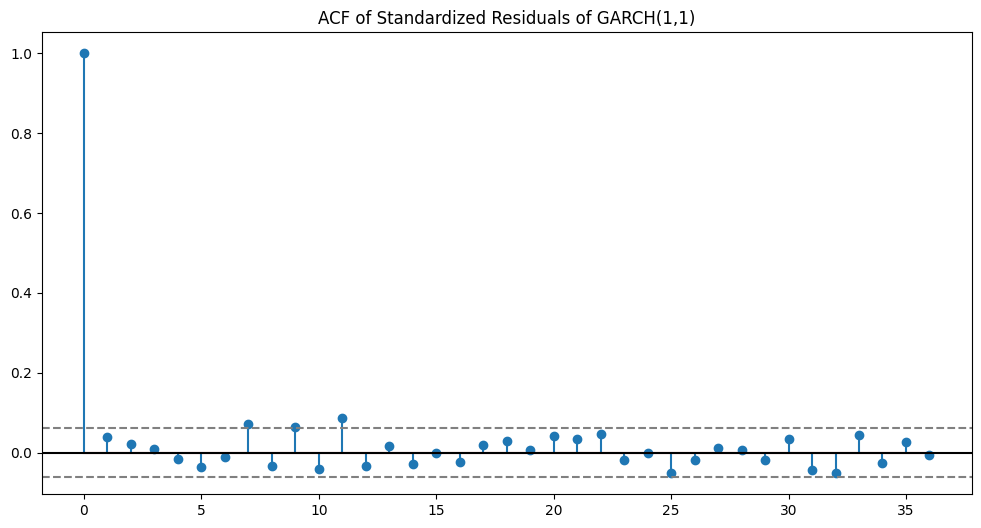

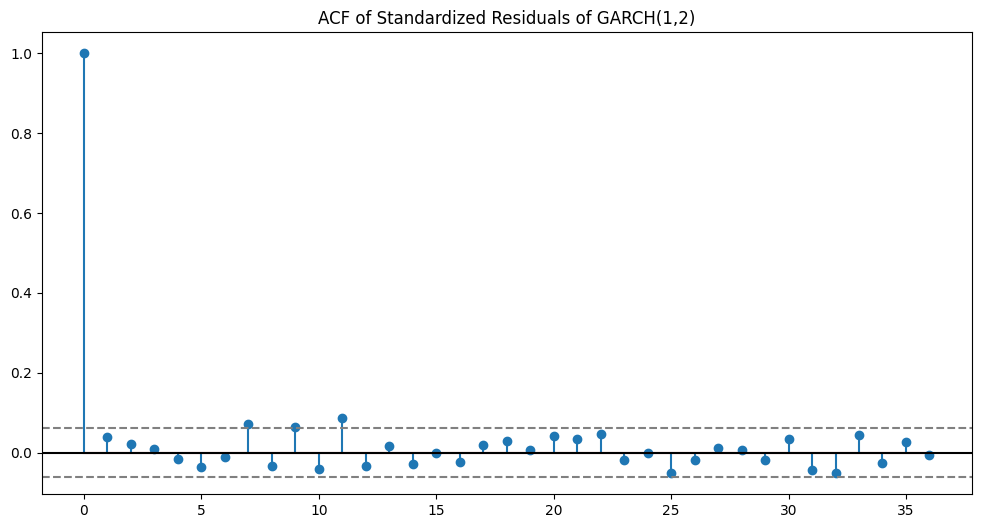

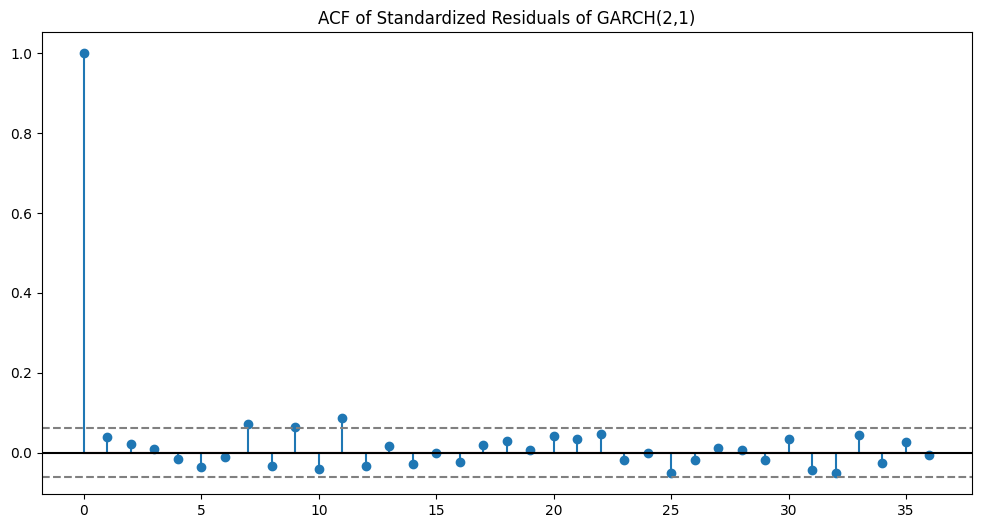

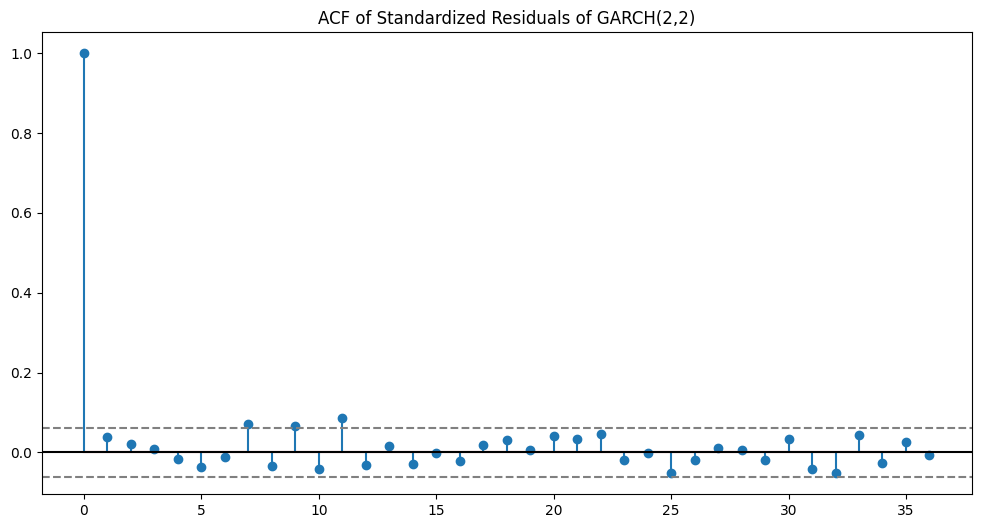

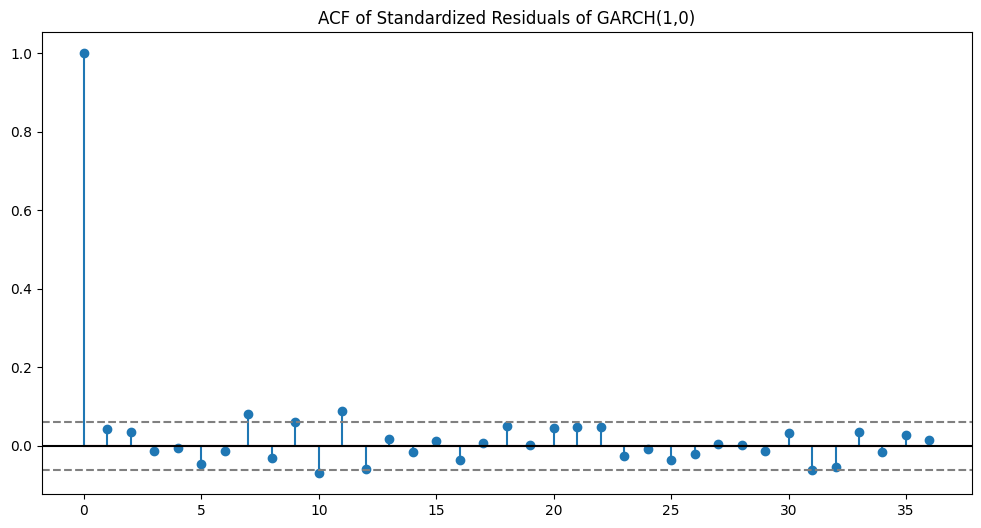

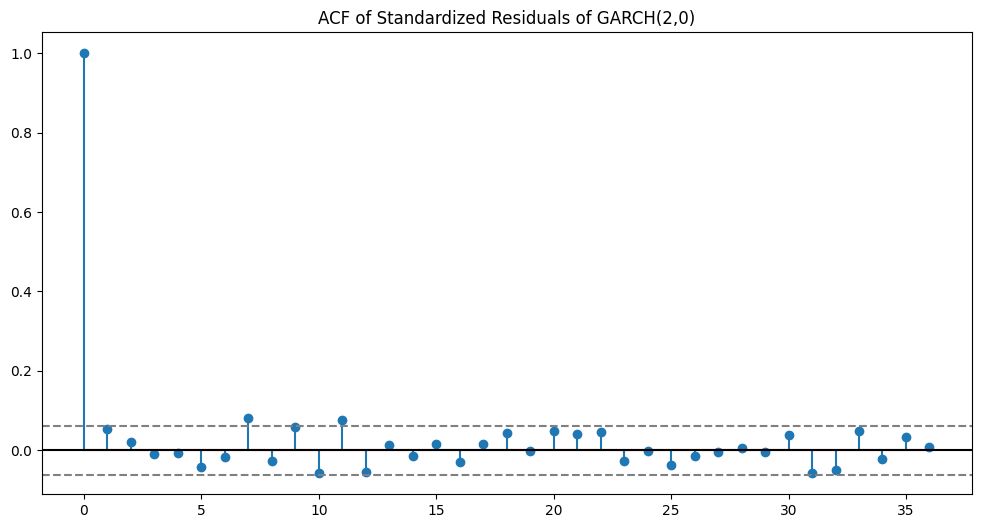

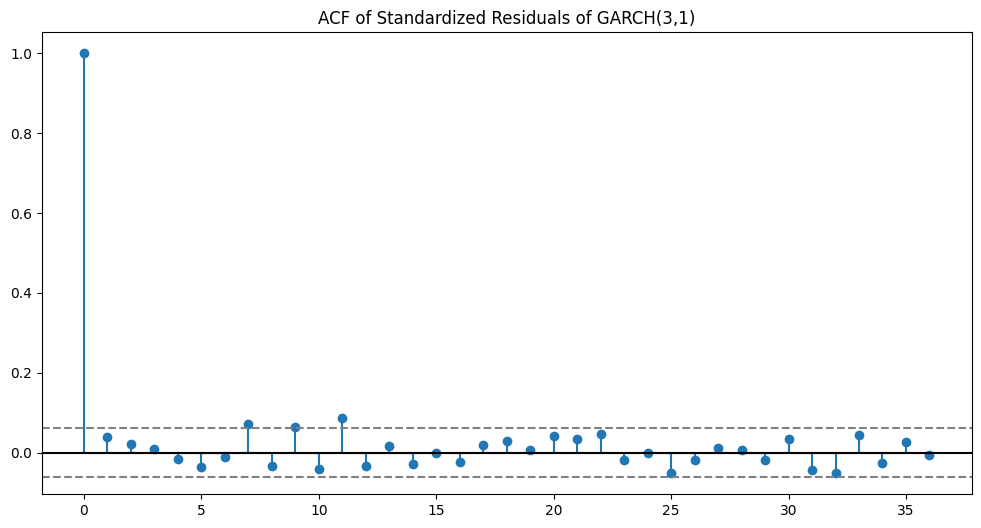

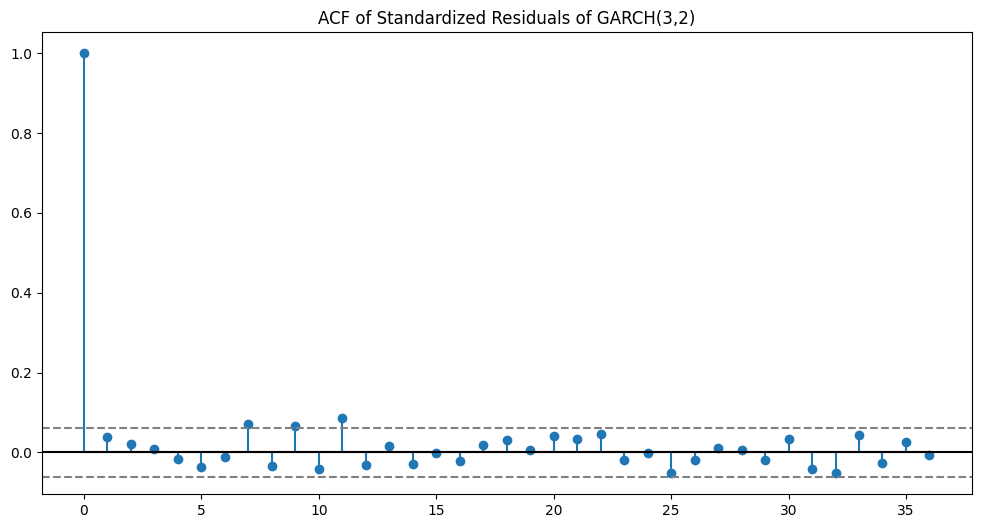

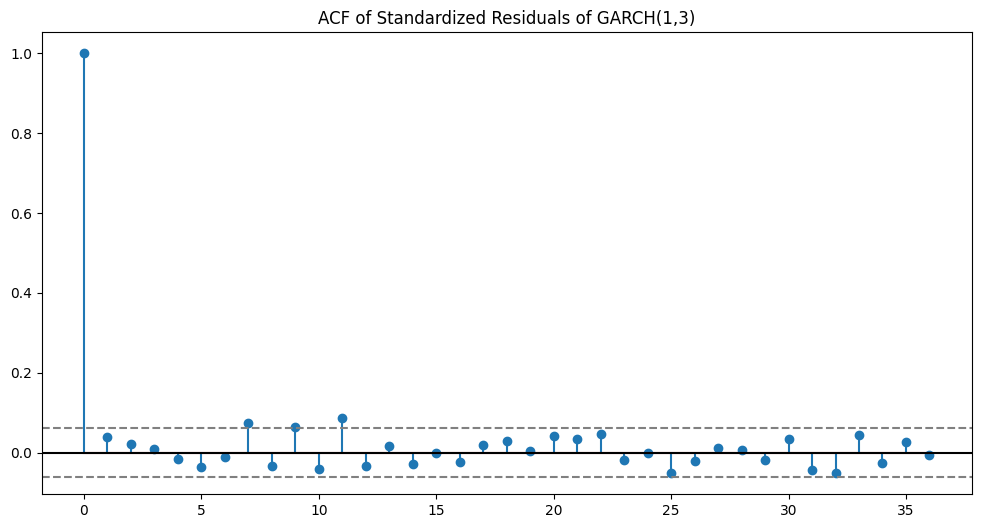

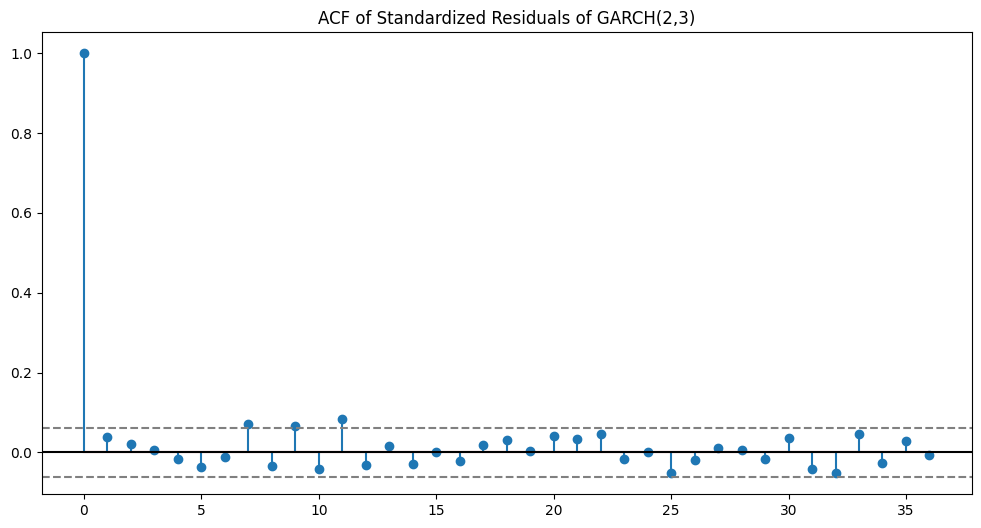

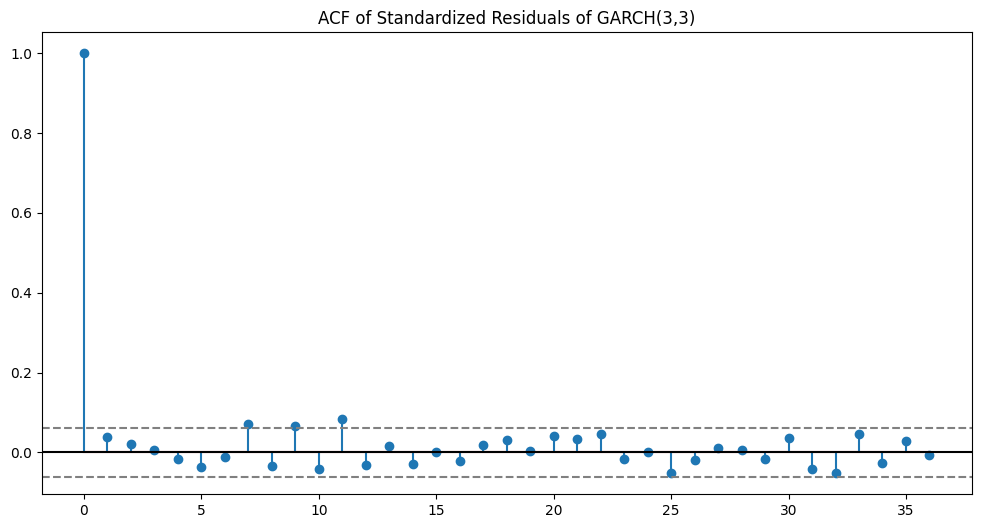

In [46]:
for name, model in models.items():
    acf(model.std_resid, nlags=36)
    plt.figure(figsize=(12, 6))
    plt.stem(range(len(acf(model.std_resid, nlags=36))), acf(model.std_resid, nlags=36))
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(model.std_resid)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(model.std_resid)), linestyle='--', color='gray')
    plt.title(f'ACF of Standardized Residuals of {name}')
    plt.show()

In [47]:
# As discussed before, we can see that there are still lags with significant autocorrelation in standardized residuals.

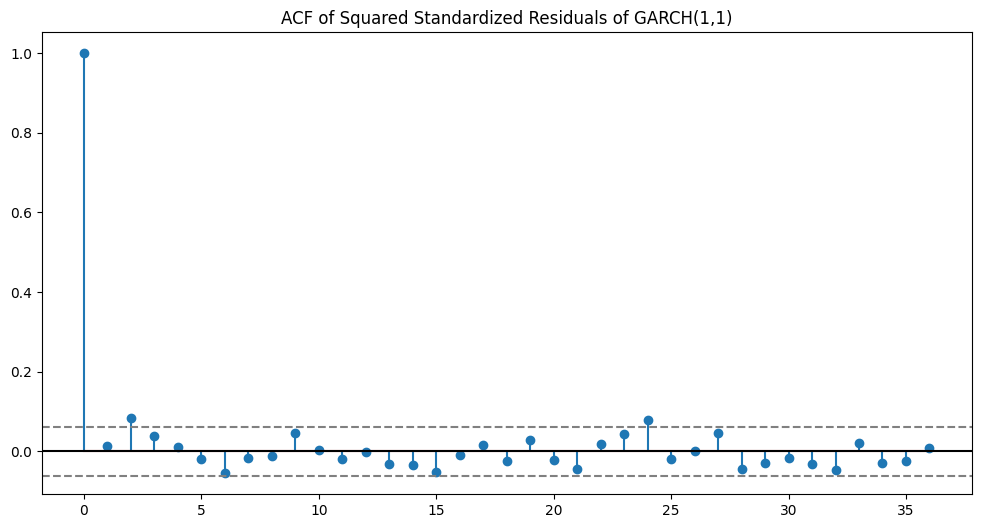

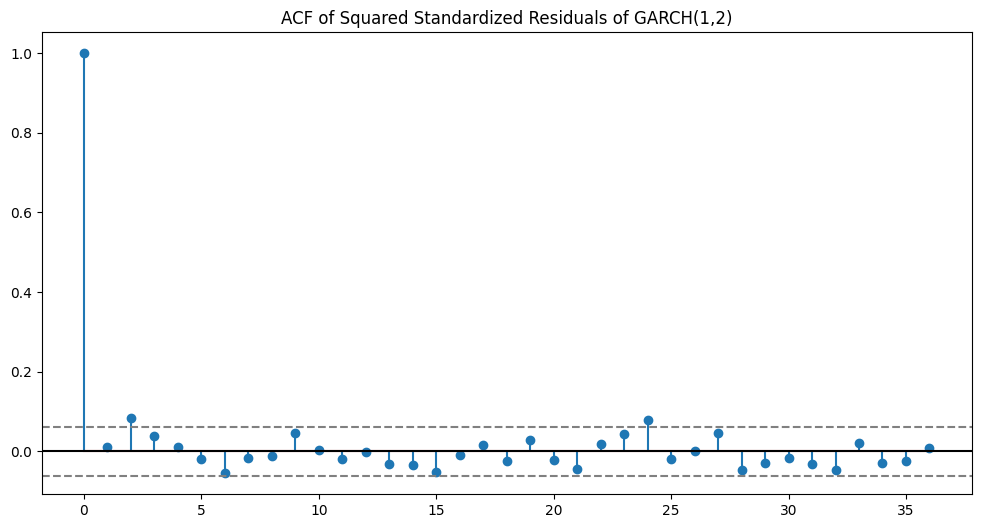

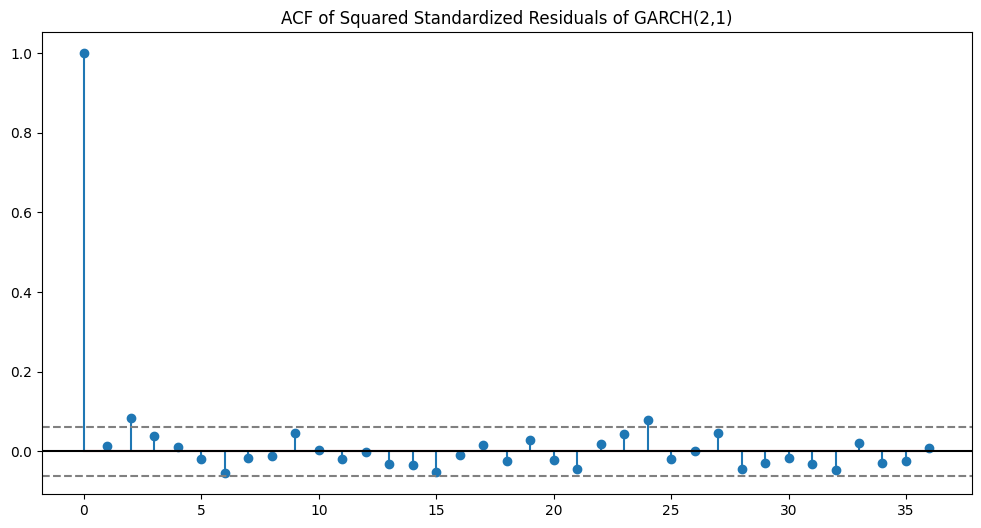

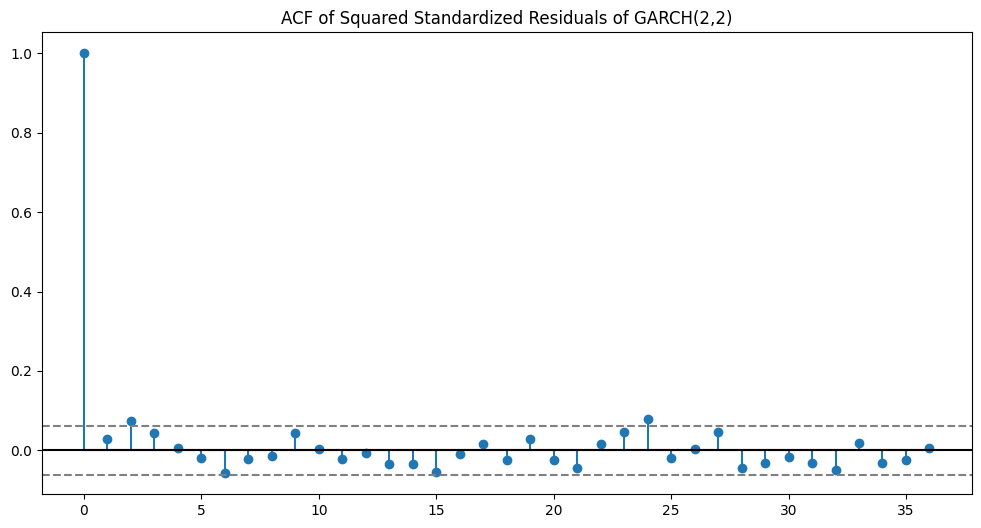

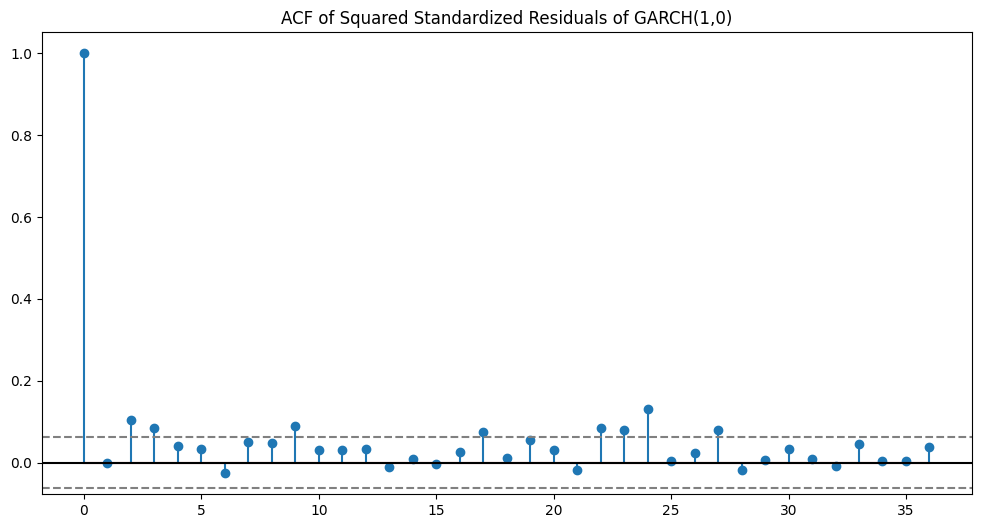

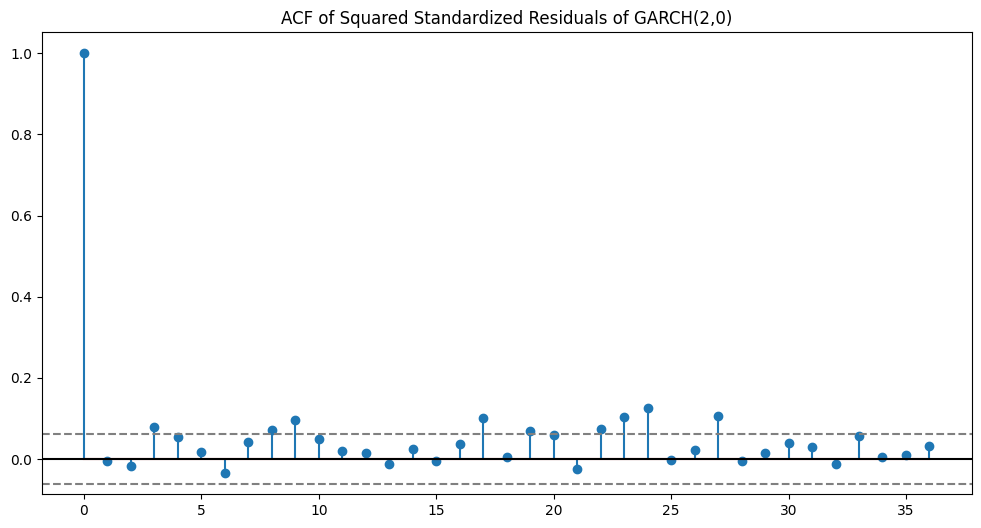

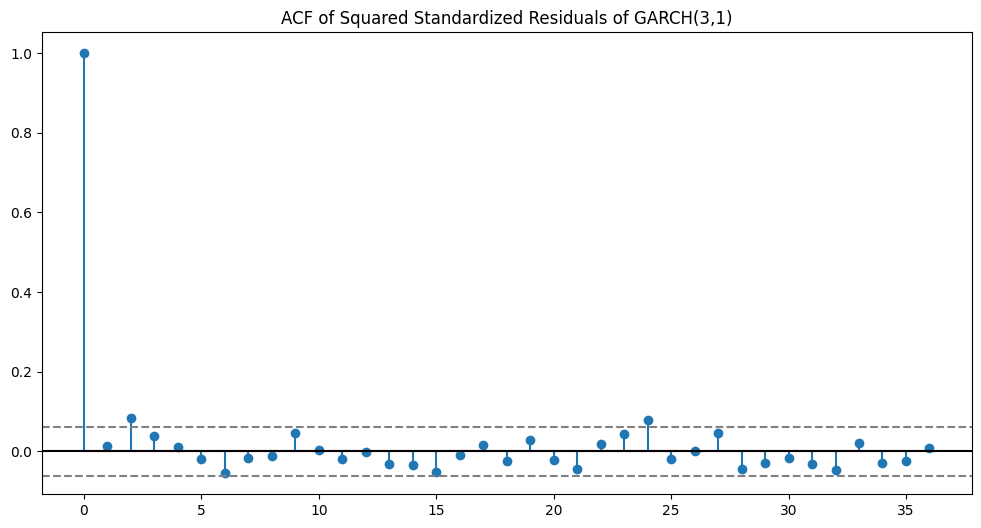

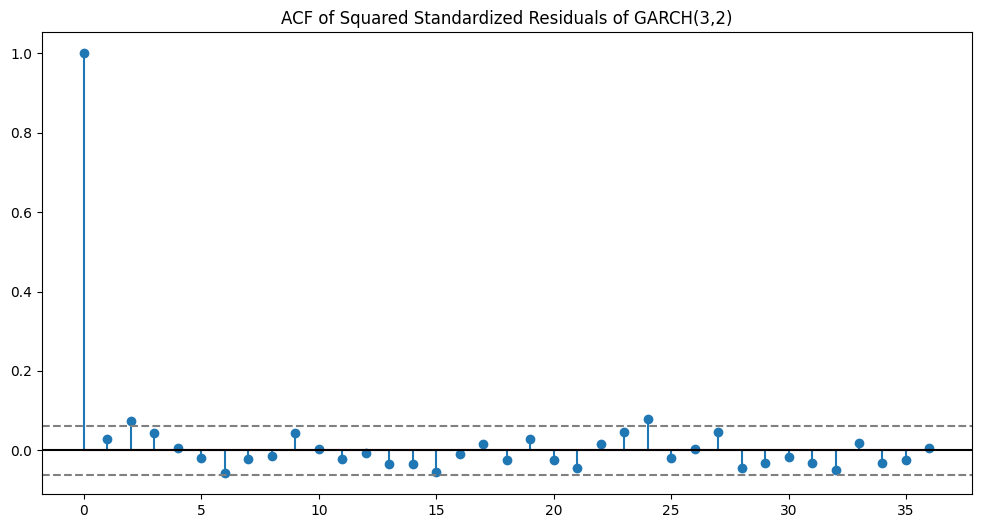

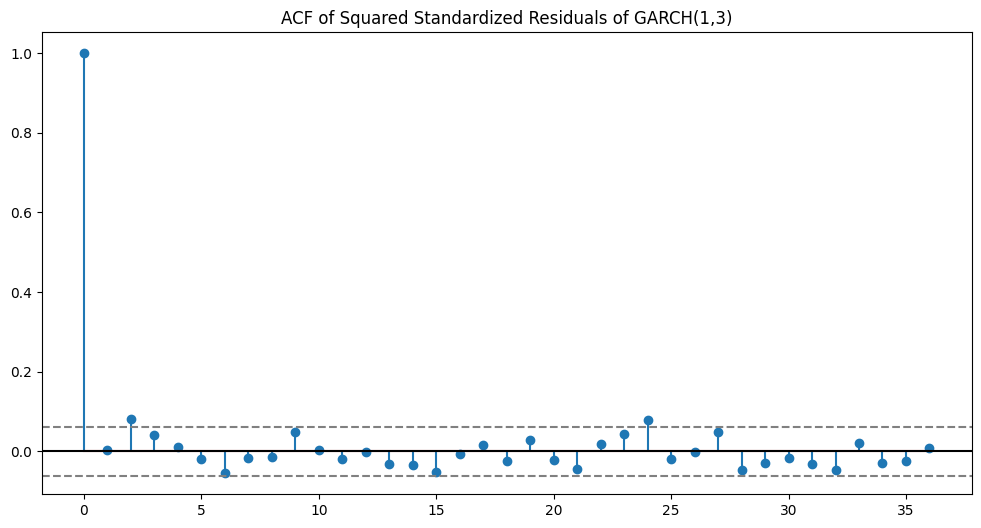

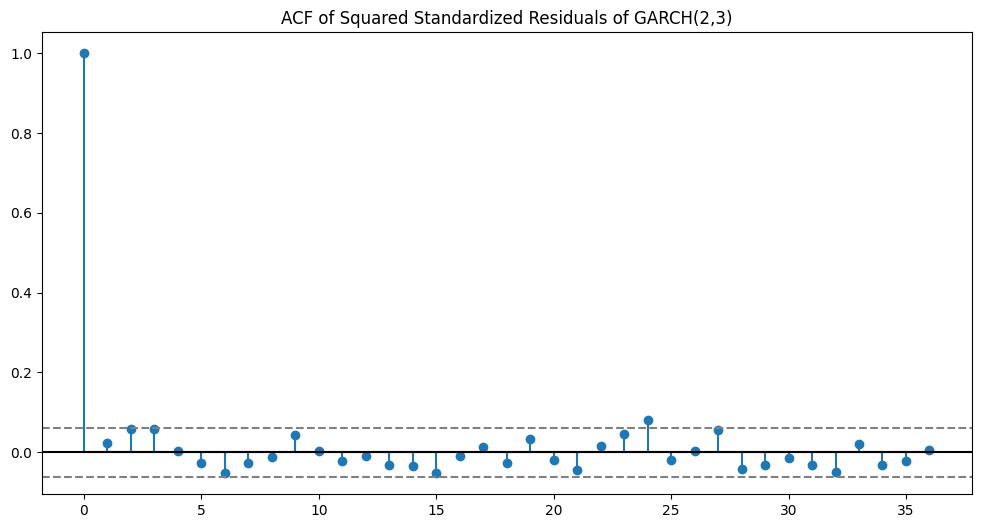

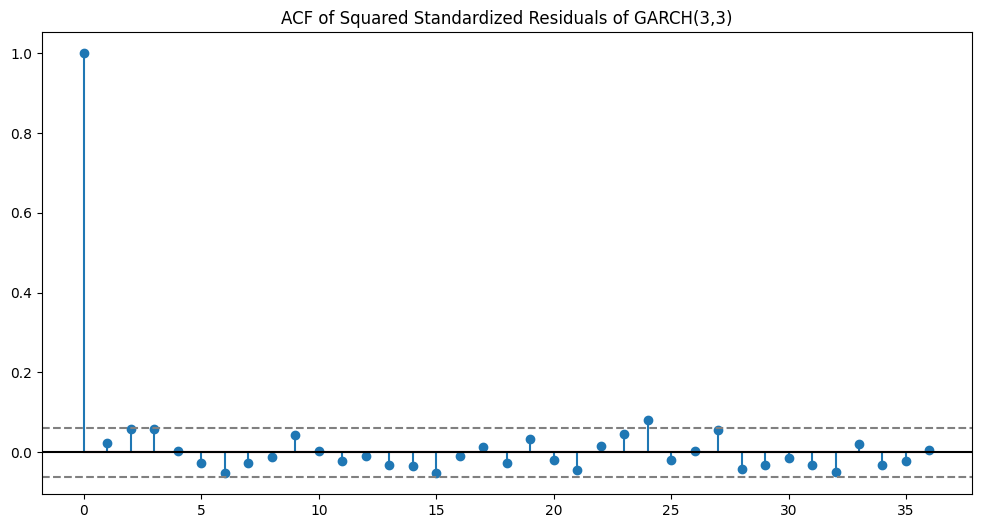

In [48]:
for name, model in models.items():
    acf(model.std_resid**2, nlags=36)
    plt.figure(figsize=(12, 6))
    plt.stem(range(len(acf(model.std_resid**2, nlags=36))), acf(model.std_resid**2, nlags=36))
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(model.std_resid**2)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(model.std_resid**2)), linestyle='--', color='gray')
    plt.title(f'ACF of Squared Standardized Residuals of {name}')
    plt.show()


In [49]:
# As we can see, there are still some lags with significant autocorrelation in squared standardized residuals, 
# but the tests confirmed that the autocorrelation is not significant enough to be seriously concerned about it.

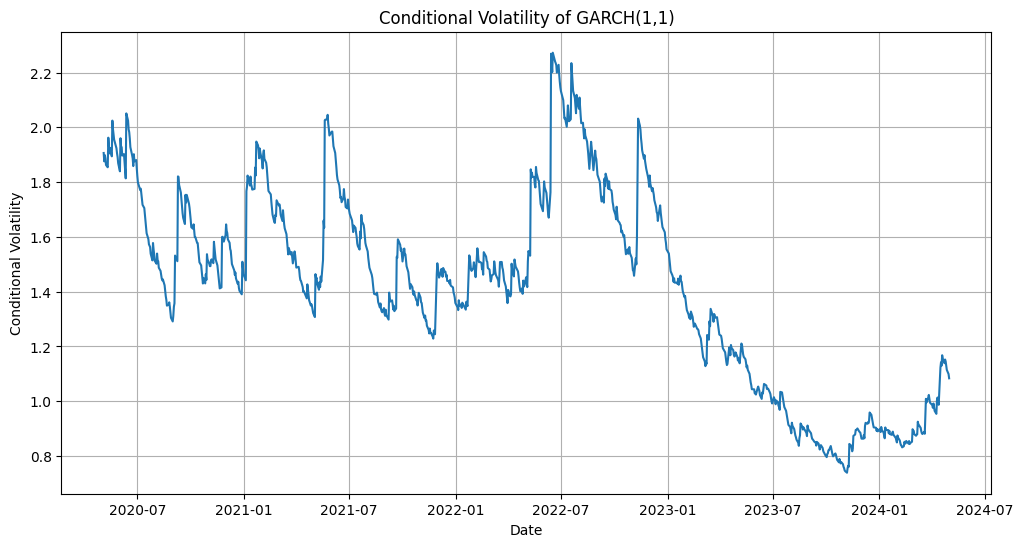

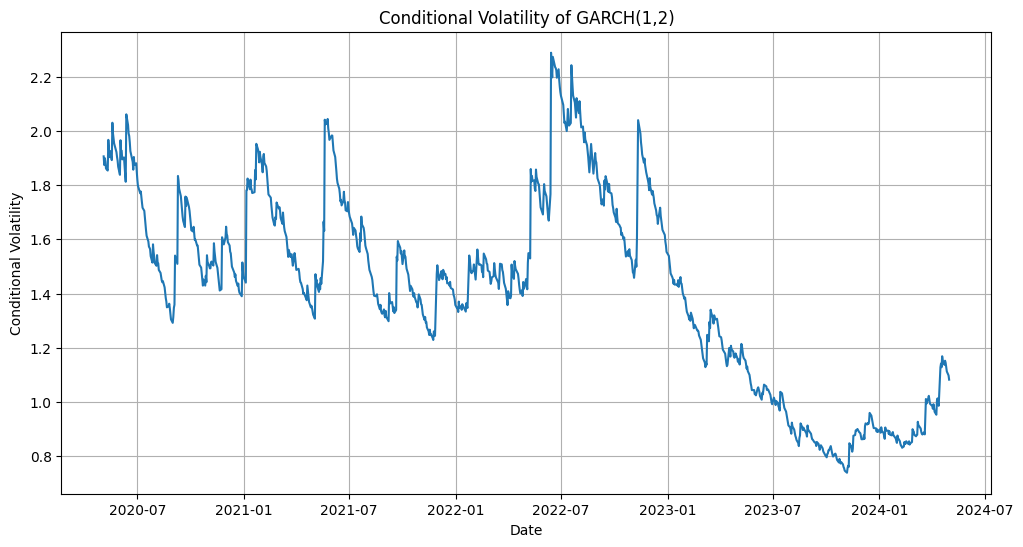

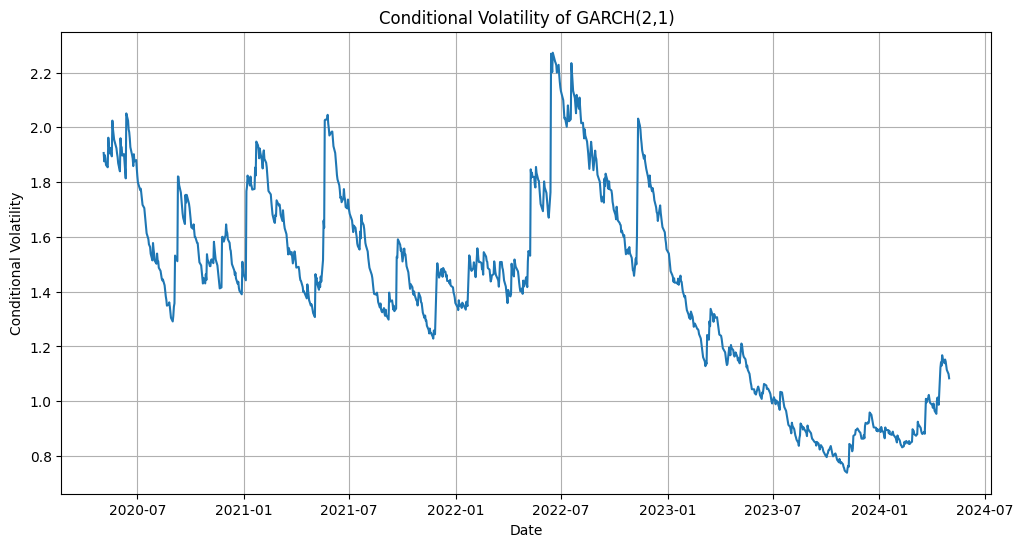

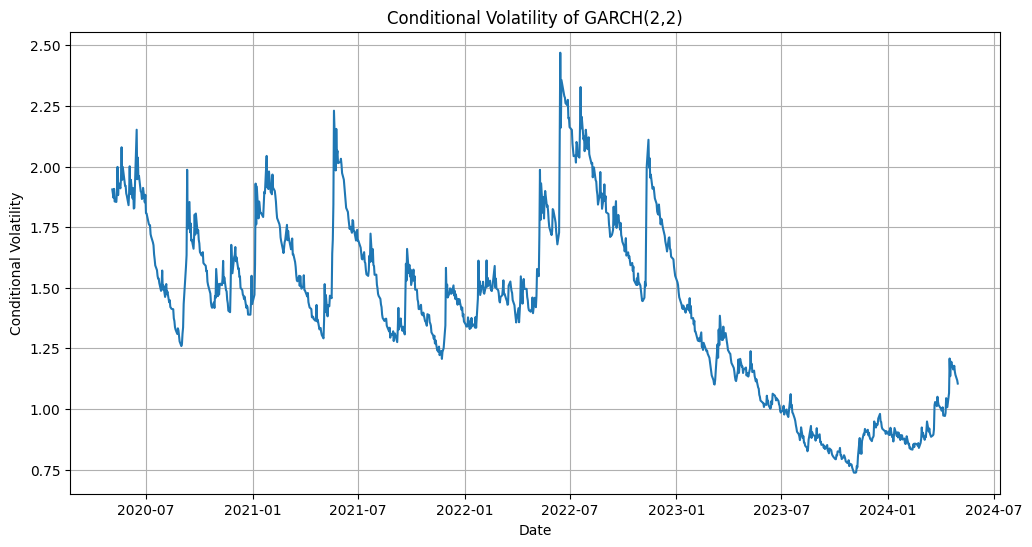

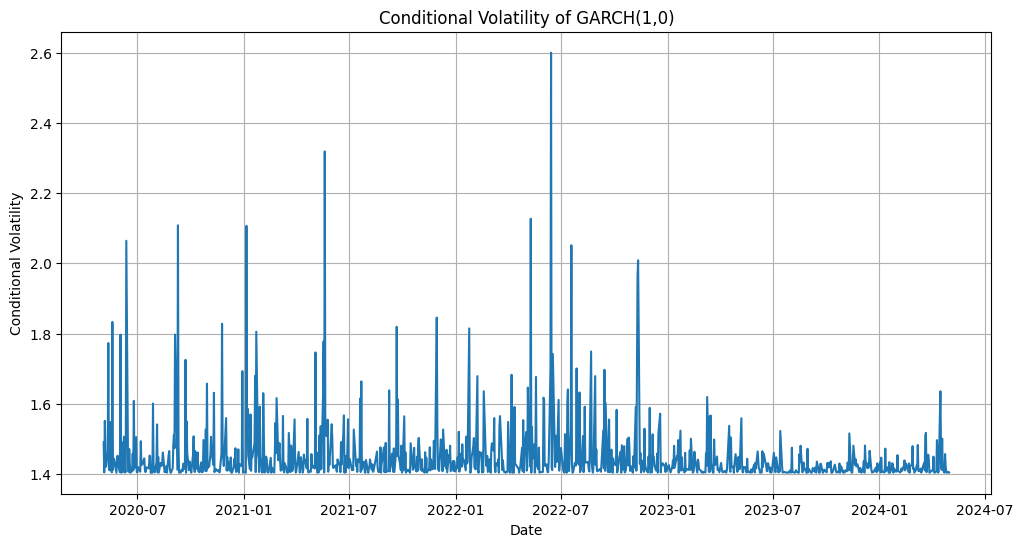

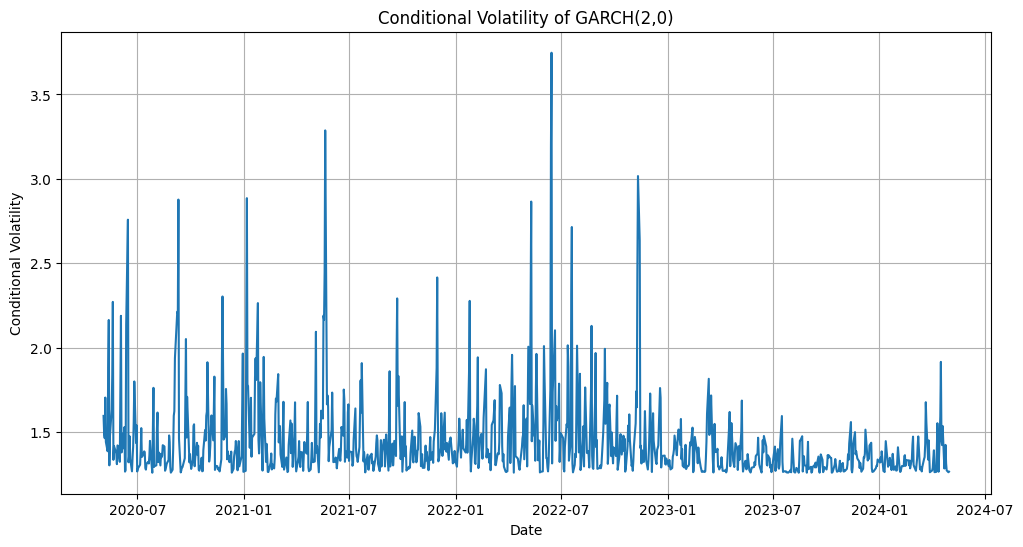

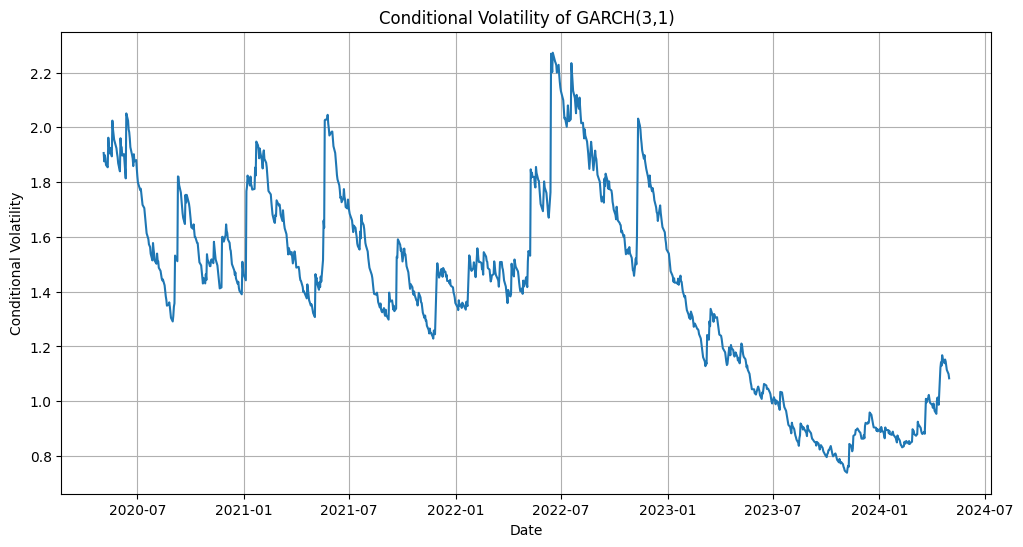

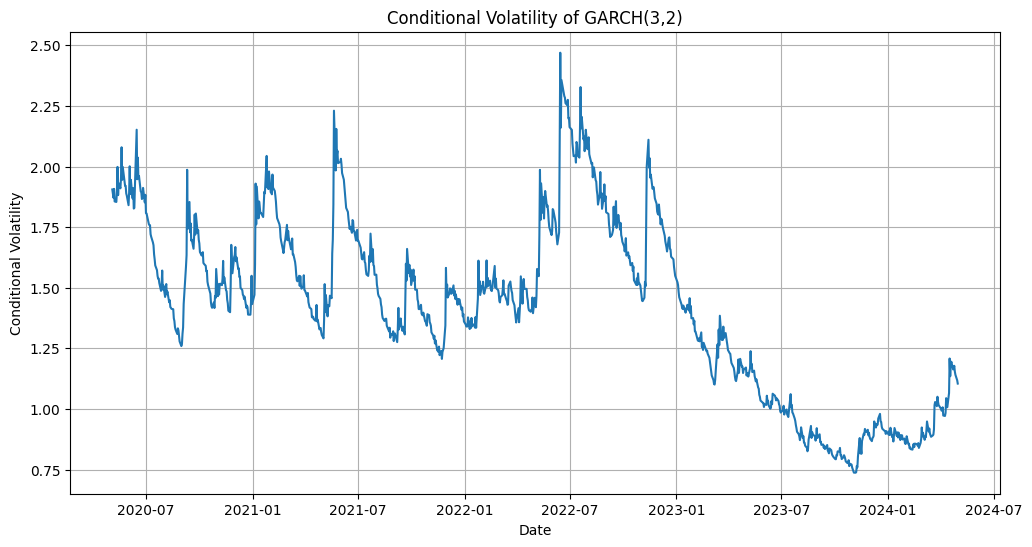

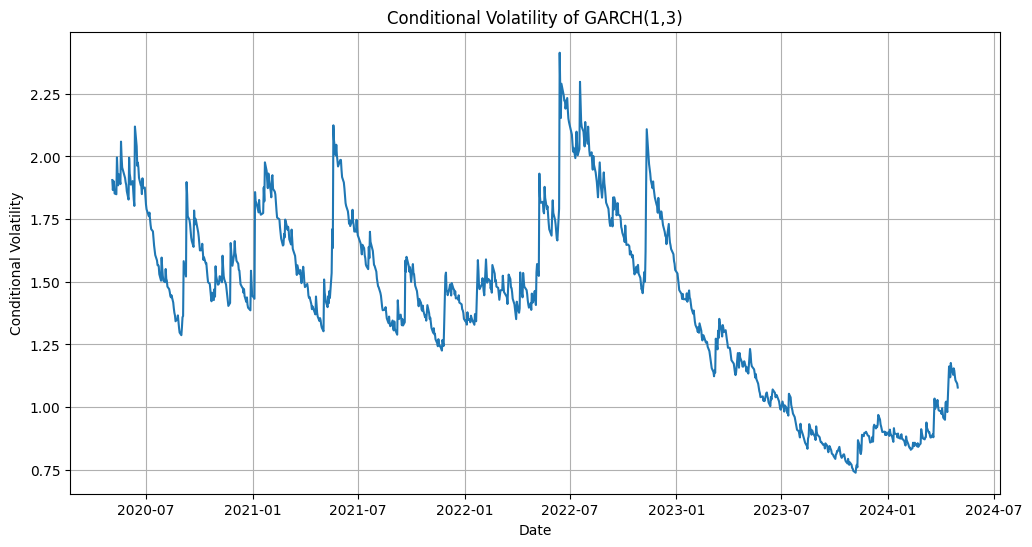

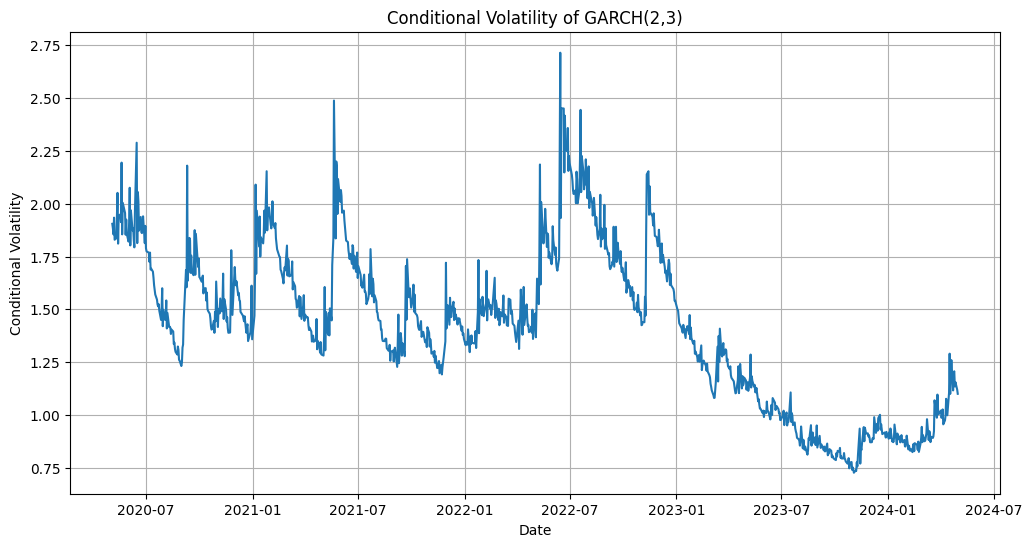

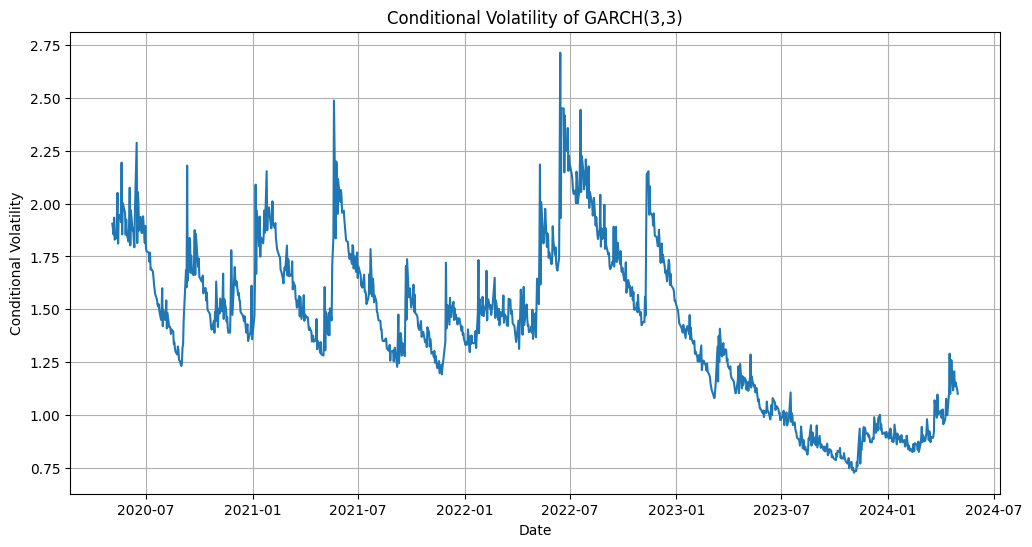

In [50]:
for name, model in models.items():
    plt.figure(figsize=(12, 6))
    plt.plot(model.conditional_volatility)
    plt.title(f'Conditional Volatility of {name}')
    plt.xlabel('Date')
    plt.ylabel('Conditional Volatility')
    plt.grid()
    plt.show()

In [51]:
model_egarch111 = arch_model(data_train['portfolio'] * 100, vol='EGARCH', p=1, o=1, q=1)
results_egarch111 = model_egarch111.fit(disp='off')
print(results_egarch111.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1748.53
Distribution:                  Normal   AIC:                           3507.05
Method:            Maximum Likelihood   BIC:                           3531.62
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:54   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1062  4.013e-02      2.646  8.137e-03 [2.754e-0

In [52]:
model_egarch121 = arch_model(data_train['portfolio'] * 100, vol='EGARCH', p=1, o=2, q=1)
results_egarch121 = model_egarch121.fit(disp='off')
print(results_egarch121.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1740.58
Distribution:                  Normal   AIC:                           3493.16
Method:            Maximum Likelihood   BIC:                           3522.63
                                        No. Observations:                 1005
Date:                Mon, Jul 07 2025   Df Residuals:                     1004
Time:                        07:02:54   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1111  3.929e-02      2.829  4.675e-03 [3.413e-0

In [53]:
# For our second model we chose EGARCH(1,2,1) because it has lower information criteria values than EGARCH(1,1,1),
# and the gamma parameters are statistically significant, which is not the case for the first model.

# This model has all parameters statistically significant, except for omega, which is the long-term average volatility.
# Gamma coefficients show that the leverage effect is present, with negative gamma indicating that negative shocks have a greater impact on volatility 
# on the next day, but the day after that this effect is reversed.
# All parameters have correct signs, epsecially gamma, which confirms the presence of leverage effect.

In [54]:
lr_stat  = 2*(results_egarch121.loglikelihood - results_egarch111.loglikelihood)
df       = results_egarch121.num_params - results_egarch111.num_params
p_value  = 1 - stats.chi2.cdf(lr_stat, df)
print(f"LR stat={lr_stat:.2f}, df={df}, p‐value={p_value:.3f}")

LR stat=15.90, df=1, p‐value=0.000


In [55]:
# The likelihood ratio test shows us that the more basic model is not sufficient, and the additional assymetry parameter is worth adding.

In [56]:
lr_stat  = 2*(results_egarch121.loglikelihood - results_garch11.loglikelihood)
df       = results_egarch121.num_params - results_garch11.num_params
p_value  = 1 - stats.chi2.cdf(lr_stat, df)
print(f"LR stat={lr_stat:.2f}, df={df}, p‐value={p_value:.3f}")

LR stat=16.24, df=2, p‐value=0.000


In [57]:
# The likelihood ratio test shows us that the GARCH is not sufficient when compared to EGARCH, and the additional assymetry parameters should improve the results.

In [58]:
good_models = {
    'GARCH(1,1)': results_garch11,
    'EGARCH(1,2,1)': results_egarch121
}

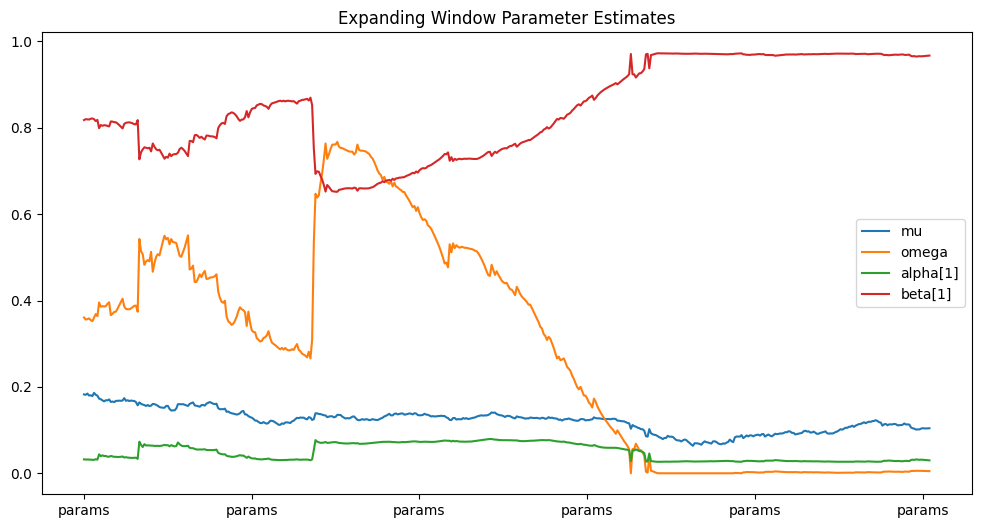

In [59]:
# Alternative stability test since Nyblom is not available in Python
window = 500
params = []

for i in range(window, len(data_train['portfolio'])):
    model_stability = arch_model(data_train['portfolio'][:i] * 100, vol='GARCH', p=1, q=1)
    res = model_stability.fit(disp='off')
    params.append(res.params)

params_df = pd.DataFrame(params)
params_df.plot(title='Expanding Window Parameter Estimates', figsize=(12, 6))
plt.show()

In [60]:
# This plot of expanding window GARCH(1,1) parameter estimates reveals instability in the first 2/3 of the sample.
# After an initial period, the parameters exhibit a sharp structural break where `beta[1]`
# jumps up and `omega` drops down. Following this break, the parameters
# enter a period of relative stability. 
# This chart is difficult to interpret, but it suggests that the parameters might be generally stable in the last stages of the sample,
# indicating that the model is likely well-specified after getting some more data.

In [61]:
def sign_bias_test(results):
    """
    Performs the Engle-Ng Sign Bias Test manually.
    
    Parameters:
        results: A fitted ARCHModelResult object from the `arch` library.
    
    Returns:
        A pandas DataFrame with the test results.
    """
    # 1. Get the necessary residuals from the GARCH model results
    std_resid = results.std_resid
    resid = results.resid
    
    # 2. Create the squared standardized residuals (dependent variable)
    y = (std_resid**2).iloc[1:]
    
    # 3. Create the independent variables based on lagged raw residuals
    # Lagged negative sign indicator (S_t-1)
    s_minus_lag1 = (resid.shift(1) < 0).astype(float).iloc[1:]
    
    # Negative size bias term (S_t-1 * e_t-1)
    neg_size_term = s_minus_lag1 * resid.shift(1).iloc[1:]
    
    # Positive size bias term ((1 - S_t-1) * e_t-1)
    # Note: 1 - S_t-1 is the indicator for positive shocks
    pos_size_term = (1 - s_minus_lag1) * resid.shift(1).iloc[1:]
    
    # 4. Combine into a DataFrame for the regression
    X = pd.concat([s_minus_lag1, neg_size_term, pos_size_term], axis=1)
    X.columns = ['Sign Bias', 'Negative Size Bias', 'Positive Size Bias']
    X = sm.add_constant(X) # Add the intercept
    
    # 5. Run the OLS regression
    ols_model = sm.OLS(y, X).fit()
    
    # 6. Calculate the Joint Test statistic and p-value
    r_squared = ols_model.rsquared
    n = ols_model.nobs
    joint_stat = n * r_squared
    joint_p_value = 1 - chi2.cdf(joint_stat, df=3)
    
    # 7. Format and return the results
    t_test_results = ols_model.summary2().tables[1]
    
    joint_test_df = pd.DataFrame({
        'Statistic': [joint_stat],
        'P-value': [joint_p_value]
    }, index=['Joint Test'])
    
    # Combine individual t-tests and the joint chi2 test
    full_results = pd.concat([
        t_test_results[['t', 'P>|t|']].rename(columns={'t': 'Statistic', 'P>|t|': 'P-value'}),
        joint_test_df
    ])
    # We don't care about the intercept's t-test
    return full_results.drop('const')

test_results_garch11 = sign_bias_test(results_garch11)
print("Sign Bias Test Results:")
print(test_results_garch11)

Sign Bias Test Results:
                    Statistic   P-value
Sign Bias            1.603851  0.109063
Negative Size Bias  -0.165313  0.868731
Positive Size Bias  -0.784368  0.433010
Joint Test          10.139123  0.017420


In [62]:
# The Sign Bias Test fails (Joint Test p-value = 0.017), indicating model misspecification.
# The issue most likely stems from a general sign bias, meaning the model doesn't properly capture
# the asymmetric impact of positive vs. negative shocks. An asymmetric model should be used.

In [63]:
def pearson_gof_test_normal(results, num_bins=20):
    """
    Performs the Adjusted Pearson Chi-Squared Goodness-of-Fit test
    for a GARCH model fitted with a Normal distribution.

    Parameters:
        results: A fitted ARCHModelResult object from the `arch` library.
                 The model MUST have been fitted with dist='normal'.
        num_bins (int): The number of groups to bin the data into.
                        Common choices are between 10 and 40.

    Returns:
        A dictionary with the test statistic, degrees of freedom, and p-value.
    """

    # 1. Get standardized residuals from the model
    std_resid = results.std_resid
    n_obs = len(std_resid)

    # 2. Define bin edges from the standard normal distribution (our H0)
    # We create bins that have equal expected probability (1/num_bins)
    bin_probabilities = np.linspace(0, 1, num_bins + 1)
    bin_edges = norm.ppf(bin_probabilities)

    # 3. Count the number of observed residuals falling into each bin
    observed_freq, _ = np.histogram(std_resid, bins=bin_edges)

    # 4. Calculate the expected frequency for each bin
    # Under the null hypothesis, each bin has an equal number of observations
    expected_freq = n_obs / num_bins

    # 5. Calculate the Pearson Chi-Squared statistic
    # It's the sum of (Observed - Expected)^2 / Expected
    chi2_stat = np.sum((observed_freq - expected_freq)**2 / expected_freq)

    # 6. Calculate the ADJUSTED degrees of freedom
    num_params = len(results.params)
    df = num_bins - 1 - num_params

    # Check for a valid number of degrees of freedom
    if df <= 0:
        raise ValueError(f"Degrees of freedom ({df}) must be positive. "
                         "Increase `num_bins` or use a simpler model.")

    # 7. Calculate the final p-value from the Chi-Squared distribution
    p_value = chi2.sf(chi2_stat, df)  # .sf is the survival function (1 - cdf)

    return {
        'chi2_statistic': chi2_stat,
        'degrees_of_freedom': df,
        'p_value': p_value
    }

gof_test_results = pearson_gof_test_normal(results_garch11, num_bins=25)

print("--- Adjusted Pearson Goodness-of-Fit Test ---")
print(f"Chi-Squared Statistic: {gof_test_results['chi2_statistic']:.4f}")
print(f"Degrees of Freedom:    {gof_test_results['degrees_of_freedom']}")
print(f"P-value:               {gof_test_results['p_value']:.4f}")

if gof_test_results['p_value'] < 0.05:
    print("\nResult: Reject the null hypothesis. The residuals do not appear to be normally distributed.")
else:
    print("\nResult: Fail to reject the null hypothesis. The normal distribution is a plausible fit.")

--- Adjusted Pearson Goodness-of-Fit Test ---
Chi-Squared Statistic: 30.9950
Degrees of Freedom:    20
P-value:               0.0553

Result: Fail to reject the null hypothesis. The normal distribution is a plausible fit.


In [64]:
# The Adjusted Pearson GOF test results in a borderline p-value of 0.0553.
# While this technically passes at the 5% significance level, it suggests the
# normal distribution is only a plausible, not a strong, fit for the residuals.

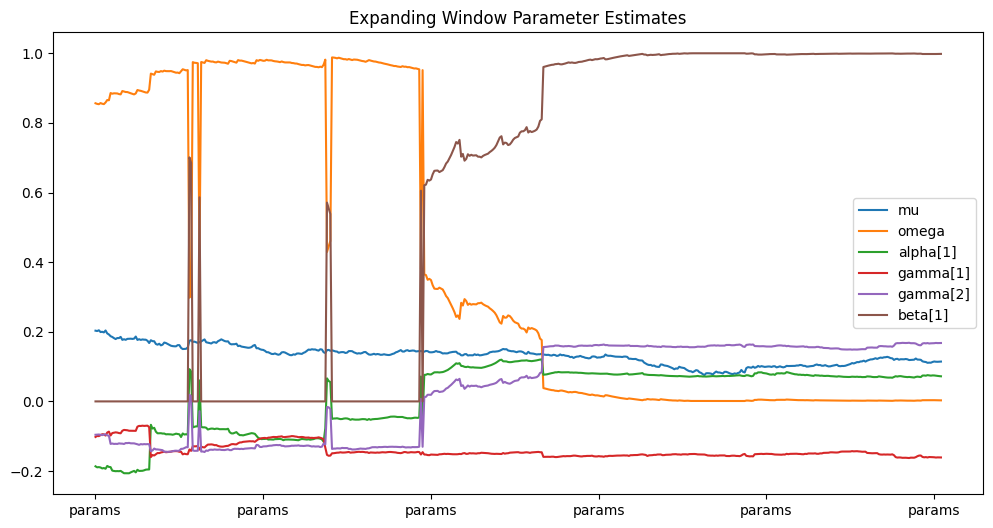

In [65]:
window = 500
params = []

for i in range(window, len(data_train['portfolio'])):
    model_stability = arch_model(data_train['portfolio'][:i] * 100, vol='EGARCH', p=1, o=2, q=1)
    res = model_stability.fit(disp='off')
    params.append(res.params)

params_df = pd.DataFrame(params)
params_df.plot(title='Expanding Window Parameter Estimates', figsize=(12, 6))
plt.show()

In [66]:
# The rolling parameter estimates show extreme instability when still learning the first half of the sample, 
# including several apparent estimation failures (V-shaped crashes).
# In the second half, the parameters stabilize and almost do not change,
# indicating that the model is likely well-specified after getting some more data.

In [67]:
test_results_egarch121 = sign_bias_test(results_egarch121)
print("Sign Bias Test Results:")
print(test_results_egarch121)

Sign Bias Test Results:
                    Statistic   P-value
Sign Bias            1.137447  0.255624
Negative Size Bias   0.859703  0.390159
Positive Size Bias   0.111485  0.911254
Joint Test           1.679745  0.641446


In [68]:
# The Sign Bias Test passes successfully.
# This indicates that the model is well-specified and correctly captures the
# asymmetric response to positive and negative shocks. No adjustments are needed.

In [69]:
gof_test_results = pearson_gof_test_normal(results_egarch121, num_bins=25)

print("--- Adjusted Pearson Goodness-of-Fit Test ---")
print(f"Chi-Squared Statistic: {gof_test_results['chi2_statistic']:.4f}")
print(f"Degrees of Freedom:    {gof_test_results['degrees_of_freedom']}")
print(f"P-value:               {gof_test_results['p_value']:.4f}")

if gof_test_results['p_value'] < 0.05:
    print("\nResult: Reject the null hypothesis. The residuals do not appear to be normally distributed.")
else:
    print("\nResult: Fail to reject the null hypothesis. The normal distribution is a plausible fit.")

--- Adjusted Pearson Goodness-of-Fit Test ---
Chi-Squared Statistic: 31.1443
Degrees of Freedom:    18
P-value:               0.0277

Result: Reject the null hypothesis. The residuals do not appear to be normally distributed.


In [70]:
# The Adjusted Pearson Goodness-of-Fit test rejects the null hypothesis.
# This provides clear evidence that the standardized residuals are not normally distributed,
# meaning the model's distributional assumption is incorrect.

In [71]:
def news_impact_curve(shocks, omega, alpha, beta): 
    variances = omega + alpha * shocks**2 + beta * (omega / (1 - alpha - beta))
    return variances 

In [72]:
def news_impact_curve_egarch(shocks, fitted_model):
    params = fitted_model.params
    omega = params['omega']
    alpha = params['alpha[1]']
    gamma = params.get('gamma[1]', 0.0)
    beta  = params['beta[1]']

    m = np.sqrt(2/np.pi)

    ln_sigma2_uncond = omega / (1 - beta)

    shocks = np.asarray(shocks)

    ln_sigma2 = (
        omega
        + alpha * (np.abs(shocks) - m)
        + gamma * shocks
        + beta * ln_sigma2_uncond
    )

    return np.exp(ln_sigma2)

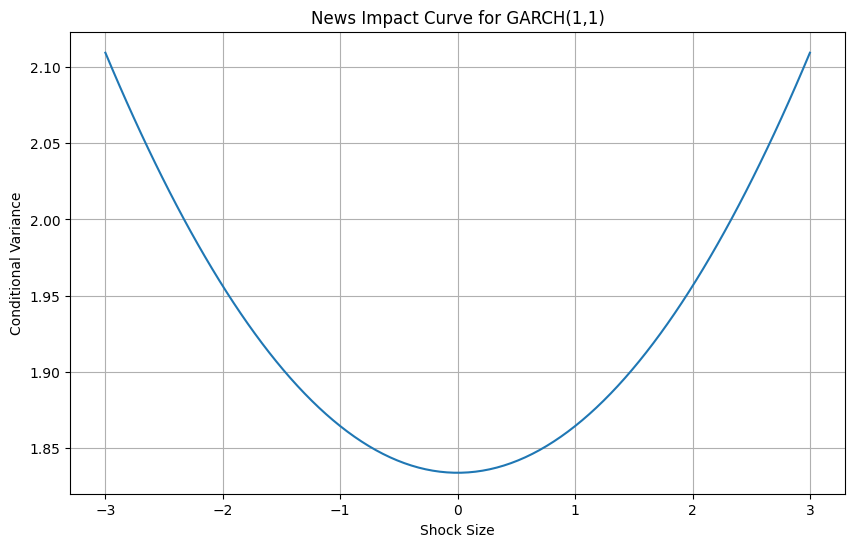

In [73]:
variances = news_impact_curve(np.linspace(-3, 3, 100),
                                    results_garch11.params['omega'],
                                    results_garch11.params['alpha[1]'],
                                    results_garch11.params['beta[1]'])
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(-3, 3, 100), variances)
plt.title(f'News Impact Curve for GARCH(1,1)')
plt.xlabel('Shock Size')
plt.ylabel('Conditional Variance')
plt.grid()
plt.show()  

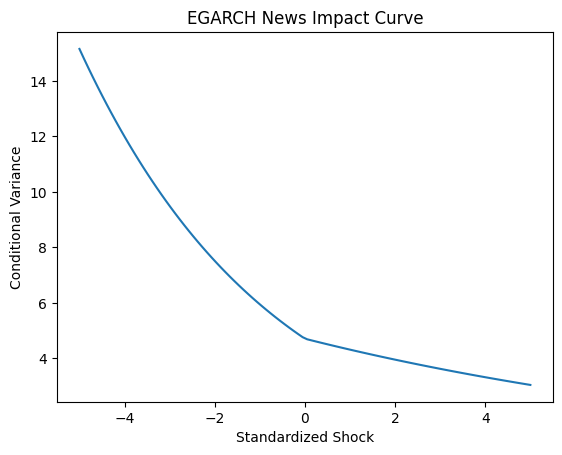

In [74]:
x = np.linspace(-5, 5, 100) 
vic = news_impact_curve_egarch(x, results_egarch121)
plt.plot(x, vic)
plt.title("EGARCH News Impact Curve")
plt.xlabel("Standardized Shock")
plt.ylabel("Conditional Variance")
plt.show()

In [75]:
# The news impact curves show that for GARCH the response to shocks is symmetric,
# while for EGARCH the response is asymmetric, with negative shocks leading to higher volatility than positive.
# This is consistent with the leverage effect, where negative shocks have a greater impact on future volatility.

# Also the EGARCH curve looks differently because it is based on the logarithm of the conditional variance,
# not the variance itself, which is why it has a different shape than the GARCH curve.

In [76]:
data_train_portfolio = data_train['portfolio'].copy()
data_train_portfolio_mean = data_train_portfolio.mean()
data_train_portfolio_std = data_train_portfolio.std()
data_train['portfolio_std'] = (data_train_portfolio - data_train_portfolio_mean) / data_train_portfolio_std

In [77]:
q01_empirical_portfolio = data_train['portfolio_std'].quantile(0.01)
conditional_volatility_garch11 = results_garch11.conditional_volatility
conditional_volatility_egarch121 = results_egarch121.conditional_volatility

data_train.loc[conditional_volatility_garch11.index, 'VaR_GARCH(1,1)'] = q01_empirical_portfolio * conditional_volatility_garch11
data_train.loc[conditional_volatility_egarch121.index, 'VaR_EGARCH(1,2,1)'] = q01_empirical_portfolio * conditional_volatility_egarch121

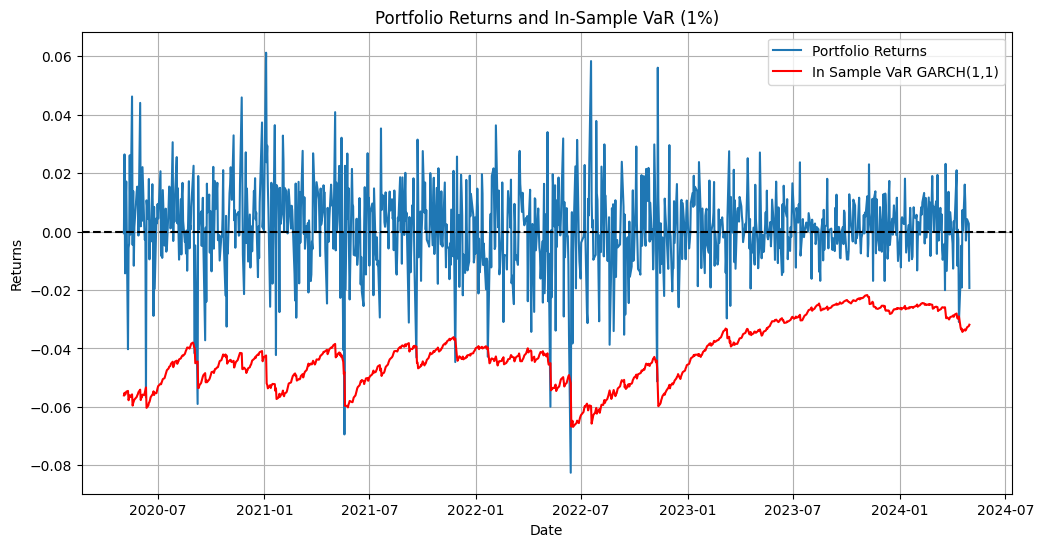

In [78]:
# Plot returns and VaR for GARCH(1,1)
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['portfolio'], label='Portfolio Returns')
plt.plot(data_train.index, data_train['VaR_GARCH(1,1)'] / 100, label='In Sample VaR GARCH(1,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and In-Sample VaR (1%)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

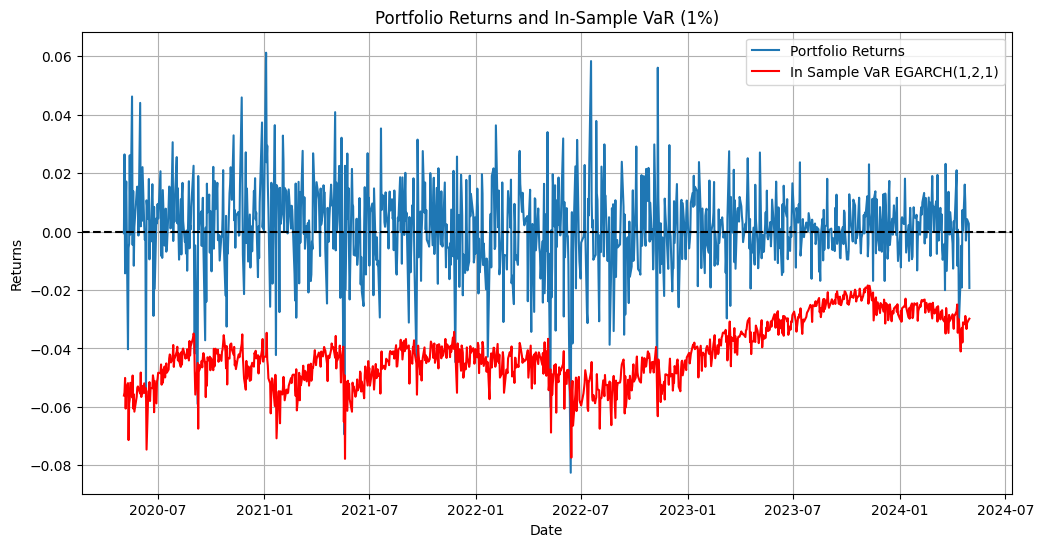

In [79]:
# Plot returns and VaR for EGARCH(1,2,1)
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['portfolio'], label='Portfolio Returns')
plt.plot(data_train.index, data_train['VaR_EGARCH(1,2,1)'] / 100, label='In Sample VaR EGARCH(1,2,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and In-Sample VaR (1%)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

In [80]:
# Number and share of observations below VaR
def calculate_var_metrics(dataframe, var_column):
    below_var = dataframe[dataframe['portfolio'] < (dataframe[var_column] / 100)]
    num_below_var = len(below_var)
    share_below_var = num_below_var / len(dataframe) * 100
    return num_below_var, share_below_var

In [81]:
below_var_garch = calculate_var_metrics(data_train, 'VaR_GARCH(1,1)')
below_var_egarch = calculate_var_metrics(data_train, 'VaR_EGARCH(1,2,1)')

print(f"GARCH(1,1) - Number of observations below VaR: {below_var_garch[0]}, Share: {below_var_garch[1]:.2f}%")
print(f"EGARCH(1,2,1) - Number of observations below VaR: {below_var_egarch[0]}, Share: {below_var_egarch[1]:.2f}%")

GARCH(1,1) - Number of observations below VaR: 11, Share: 1.09%
EGARCH(1,2,1) - Number of observations below VaR: 8, Share: 0.80%


In [82]:
# EGARCH performs better in-sample which was to be expected, because of the LR test.

In [83]:
data_test_portfolio = data_test['portfolio'].copy()
data_test_portfolio_mean = data_test_portfolio.mean()
data_test_portfolio_std = data_test_portfolio.std()
data_test['portfolio_std'] = (data_test_portfolio - data_test_portfolio_mean) / data_test_portfolio_std

In [84]:
VaR_garch11 = np.zeros(len(data_test))
VaR_egarch121 = np.zeros(len(data_test))

for i in range(len(data_test)):
    current_forecast_target_date = data_test.index[i]
    tmp_estimation_data = data[data.index < current_forecast_target_date].copy()
    tmp_estimation_data['portfolio_std'] = (tmp_estimation_data['portfolio'] - tmp_estimation_data['portfolio'].mean()) / tmp_estimation_data['portfolio'].std()
    qo1_rolling_empirical_portfolio = tmp_estimation_data['portfolio_std'].quantile(0.01)

    model_rolling_garch11 = arch_model(tmp_estimation_data['portfolio'] * 100, vol='Garch', p=1, q=1)
    results_rolling_garch11 = model_rolling_garch11.fit(disp='off')
    model_rolling_egarch121 = arch_model(tmp_estimation_data['portfolio'] * 100, vol='EGARCH', p=1, o=2, q=1)
    results_rolling_egarch121 = model_rolling_egarch121.fit(disp='off')

    forecast_rolling_garch11 = results_rolling_garch11.forecast(horizon=1, reindex=False)
    forecast_rolling_egarch121 = results_rolling_egarch121.forecast(horizon=1, reindex=False)

    sigma_forecast_rolling_garch11 = forecast_rolling_garch11.variance.iloc[-1, 0] ** 0.5
    sigma_forecast_rolling_egarch121 = forecast_rolling_egarch121.variance.iloc[-1, 0] ** 0.5

    VaR_garch11[i] = qo1_rolling_empirical_portfolio * sigma_forecast_rolling_garch11
    VaR_egarch121[i] = qo1_rolling_empirical_portfolio * sigma_forecast_rolling_egarch121



In [85]:
data_test['VaR_GARCH(1,1)'] = VaR_garch11
data_test['VaR_EGARCH(1,2,1)'] = VaR_egarch121

In [86]:
data_test

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD,portfolio,portfolio_std,"VaR_GARCH(1,1)","VaR_EGARCH(1,2,1)"
Date,,,,,,,,,
2024-05-01,0.000626,-0.051617,-0.014210,-0.007028,-0.008510,-0.016148,-1.162763,-3.310540,-3.719412
2024-05-02,-0.001043,0.002753,0.006171,0.012794,0.006472,0.005429,0.422123,-3.386320,-3.589753
2024-05-03,-0.006018,-0.008522,0.037883,0.019715,-0.000014,0.008609,0.655656,-3.337661,-3.058746
2024-05-06,0.007791,0.004450,-0.013238,0.011270,0.005040,0.003063,0.248279,-3.308663,-2.966302
2024-05-07,-0.001303,-0.002042,-0.018504,-0.000117,0.003793,-0.003635,-0.243650,-3.256452,-3.033925
...,...,...,...,...,...,...,...,...,...
2025-04-24,0.015489,0.006482,-0.014736,0.027497,-0.002817,0.006383,0.492179,-6.414053,-5.623386
2025-04-25,-0.004465,0.004797,0.009449,0.011290,0.007651,0.005744,0.445260,-6.260276,-5.473541
2025-04-28,-0.001356,-0.015219,0.006815,-0.000271,-0.002023,-0.002411,-0.153764,-6.115132,-5.343949


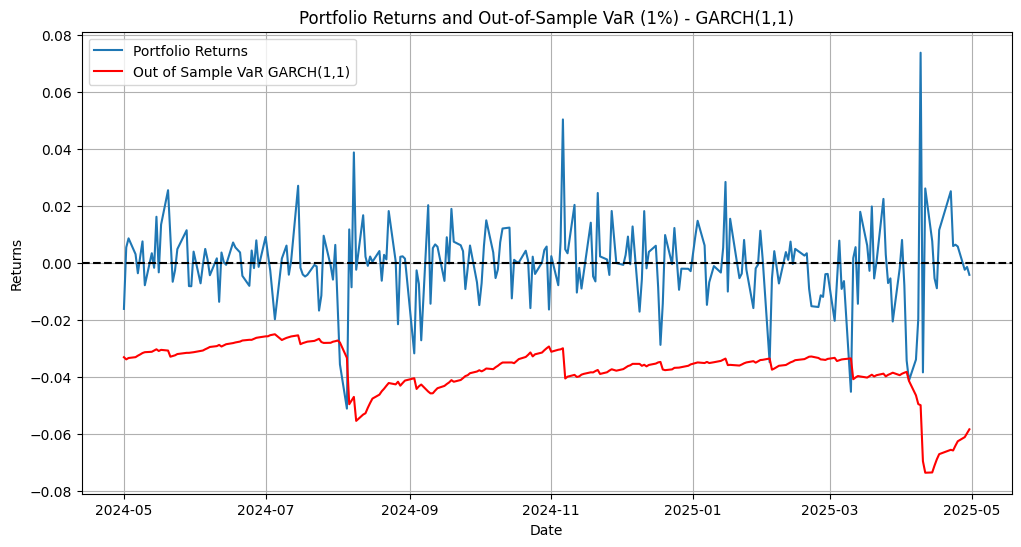

In [87]:
# Plot returns and VaR for GARCH(1,1) in test set
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test['portfolio'], label='Portfolio Returns')
plt.plot(data_test.index, data_test['VaR_GARCH(1,1)'] / 100, label='Out of Sample VaR GARCH(1,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and Out-of-Sample VaR (1%) - GARCH(1,1)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

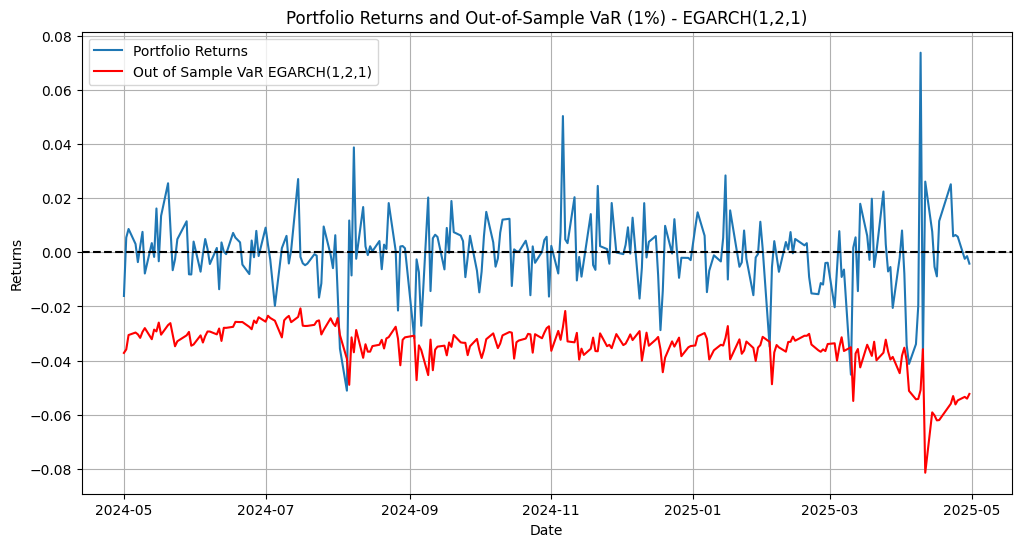

In [88]:
# Plot returns and VaR for EGARCH(1,2,1) in test set
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test['portfolio'], label='Portfolio Returns')
plt.plot(data_test.index, data_test['VaR_EGARCH(1,2,1)'] / 100, label='Out of Sample VaR EGARCH(1,2,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and Out-of-Sample VaR (1%) - EGARCH(1,2,1)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

In [89]:
# Number and share of observations below VaR in test set
below_var_test_garch = calculate_var_metrics(data_test, 'VaR_GARCH(1,1)')
below_var_test_egarch = calculate_var_metrics(data_test, 'VaR_EGARCH(1,2,1)')
print(f"GARCH(1,1) - Number of observations below VaR in test set: {below_var_test_garch[0]} out of {len(data_test)}, Share: {below_var_test_garch[1]:.2f}%")
print(f"EGARCH(1,2,1) - Number of observations below VaR in test set: {below_var_test_egarch[0]} out of {len(data_test)}, Share: {below_var_test_egarch[1]:.2f}%")

GARCH(1,1) - Number of observations below VaR in test set: 4 out of 249, Share: 1.61%
EGARCH(1,2,1) - Number of observations below VaR in test set: 6 out of 249, Share: 2.41%


In [90]:
# Although the LR test favored EGARCH, it performed worse out-of-sample.
# It might be due to overfitting, but it's difficult to pinpoint the exact reason, GARCH generalized better in VaR forecasting.
# It shows that the better in-sample fit doesn't guarantee better predictions.